## Mount the Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Topic_Modelling/transcripts/

/content/drive/MyDrive/Topic_Modelling/transcripts


In [3]:
!pip install -U contextualized_topic_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.3 MB/s 
     |████████████████████████████████| 85 kB 4.1 MB/s 
     |████████████████████████████████| 783 kB 44.4 MB/s 
     |████████████████████████████████| 121 kB 54.9 MB/s 
     |████████████████████████████████| 1.4 MB 56.8 MB/s 
     |████████████████████████████████| 1.6 MB 35.6 MB/s 
     |████████████████████████████████| 109 kB 55.3 MB/s 
     |████████████████████████████████| 4.7 MB 40.8 MB/s 
     |████████████████████████████████| 1.3 MB 43.8 MB/s 
     |████████████████████████████████| 120 kB 26.9 MB/s 
     |████████████████████████████████| 6.6 MB 39.4 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=60d69aaa26bf07659533e9583316d006ee2cd93bd56e1ec72f303d97348d058f
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc

In [4]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install pyldavis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 33.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyldavis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=a717325264ccd8412ca01a9a02b72039ba63d1fde9a96cb173553679671b0f2f
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=e31c61c601413880b5d781e30dd1520a2ed9dfcdeaa1325e86669c83007f7ba1
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built pyldavis sklearn


## Import the required libraries

In [6]:
from contextualized_topic_models.models.ctm import CombinedTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessingStopwords
import nltk

# I] Loading the Intuit dataset

In [7]:
import pickle

with open("intuit/2020Q4/896878_intuit_2020Q4.pickle", "rb") as fp:   
  data = pickle.load(fp)

print(len(data))
print(data)

3
{'transcript': {'Kim Watkins': ['\nThanks, Latif. Good afternoon. And welcome to Intuit’s fourth quarter fiscal 2020 conference call. I am here with Intuit’s CEO, Sasan Goodarzi; and Michelle Clatterbuck, our CFO.\nBefore we start, I’d like to remind everyone that our remarks will include forward-looking statements. There are a number of factors that could cause Intuit’s results to differ materially from our expectations.\nYou can learn more about these risks in the press release we issued earlier this afternoon, our Form 10-K for fiscal 2019 and our other SEC filings.\nAll of those documents are available on the Investor Relations page of Intuit’s website at intuit.com. We assume no obligation to update any forward-looking statements.\nSome of the numbers in these remarks are presented on a non-GAAP basis.\nWe have reconciled the comparable GAAP and non-GAAP numbers in today’s press release. Unless otherwise noted, all growth rates refer to the current period versus the comparable p

In [8]:
print(data['transcript'].keys())
intuit_data = data['transcript']['Kim Watkins']+data['transcript']['Sasan Goodarzi']+data['transcript']['Michelle Clatterbuck']

dict_keys(['Kim Watkins', 'Sasan Goodarzi', 'Michelle Clatterbuck', 'Brad Zelnick', 'Ken Wong', 'Robert Simmons', 'Siti Panigrahi', 'Kirk Materne', 'Brent Thill', 'Mark Rende', 'Scott Schneeberger', 'Sterling Auty', 'Jennifer Lowe', 'Michael Millman', 'Michael Turrin', 'Josh Beck', 'Kartik Mehta', 'Brad Reback', 'Operator'])


### Data Preprocessing

In [9]:
count=0
string_list=[]
for i in intuit_data:
  count = count + len (i.strip().split("\n"))
  string_list+= i.strip().split("\n") 
data_final=[]
for i in string_list:
  if (len(i)>20):
    data_final.append(i)
print(data_final[0])

Thanks, Latif. Good afternoon. And welcome to Intuit’s fourth quarter fiscal 2020 conference call. I am here with Intuit’s CEO, Sasan Goodarzi; and Michelle Clatterbuck, our CFO.


In [10]:
print(data_final)

['Thanks, Latif. Good afternoon. And welcome to Intuit’s fourth quarter fiscal 2020 conference call. I am here with Intuit’s CEO, Sasan Goodarzi; and Michelle Clatterbuck, our CFO.', 'Before we start, I’d like to remind everyone that our remarks will include forward-looking statements. There are a number of factors that could cause Intuit’s results to differ materially from our expectations.', 'You can learn more about these risks in the press release we issued earlier this afternoon, our Form 10-K for fiscal 2019 and our other SEC filings.', 'All of those documents are available on the Investor Relations page of Intuit’s website at intuit.com. We assume no obligation to update any forward-looking statements.', 'Some of the numbers in these remarks are presented on a non-GAAP basis.', 'We have reconciled the comparable GAAP and non-GAAP numbers in today’s press release. Unless otherwise noted, all growth rates refer to the current period versus the comparable prior year period, and the

In [11]:
print(len(data_final))

194


In [12]:
from nltk.corpus import stopwords as stop_words

nltk.download('stopwords')

# documents = [line.strip() for line in open(text_file, encoding="unicode_escape").readlines()]

stopwords = list(stop_words.words("english"))

sp = WhiteSpacePreprocessingStopwords(data_final, stopwords_list=stopwords)
preprocessed_documents, unpreprocessed_corpus, vocab, retained_indices = sp.preprocess()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [13]:
preprocessed_documents[:2]

['thanks latif good afternoon welcome fourth quarter fiscal conference call ceo sasan goodarzi michelle clatterbuck cfo',
 'start like remind everyone remarks include forward looking statements number factors could cause results differ materially expectations']

## i) Using all-mpnet-base-v2 Transformer

In [14]:
tp = TopicModelDataPreparation("all-mpnet-base-v2")

training_dataset = tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 252 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [15]:
tp.vocab[:10]

['ability',
 'able',
 'absolutely',
 'accelerant',
 'accelerate',
 'accelerated',
 'accelerates',
 'accelerating',
 'acceleration',
 'accept']

## Training the Combined TM

In [16]:
ctm = CombinedTM(bow_size=len(tp.vocab), contextual_size=768, n_components=20, num_epochs=10)
ctm.fit(training_dataset) # run the model

Epoch: [10/10]	 Seen Samples: [1940/1940]	Train Loss: 191.90449696963594	Time: 0:00:00.281540: : 10it [00:02,  3.35it/s]
Sampling: [20/20]: : 20it [00:04,  4.92it/s]


In [17]:
ctm.get_topic_lists(5)

[['know', 'especially', 'prs', 'rough', 'experience'],
 ['general', 'deploy', 'really', 'tracking', 'better'],
 ['gradual', 'rough', 'continue', 'launches', 'adoption'],
 ['well', 'disciplined', 'fallen', 'finally', 'yield'],
 ['ago', 'cash', 'expand', 'hire', 'apparent'],
 ['experience', 'crisis', 'play', 'platform', 'tell'],
 ['earlier', 'strongest', 'believe', 'board', 'customers'],
 ['several', 'investments', 'stakeholders', 'think', 'challenge'],
 ['quarter', 'customer', 'financial', 'making', 'around'],
 ['way', 'control', 'growth', 'call', 'focuses'],
 ['customer', 'growth', 'third', 'covid', 'levels'],
 ['approximately', 'term', 'payroll', 'year', 'especially'],
 ['bet', 'bets', 'benefit', 'approximately', 'jen'],
 ['september', 'business', 'desktop', 'monthly', 'approximately'],
 ['reminder', 'shift', 'key', 'available', 'critical'],
 ['look', 'hey', 'accurate', 'stakeholders', 'deploy'],
 ['finance', 'learned', 'dollars', 'innovation', 'low'],
 ['customers', 'revenue', 'new',

In [18]:
ctm.get_topics()

defaultdict(list,
            {0: ['know',
              'especially',
              'prs',
              'rough',
              'experience',
              'downtime',
              'expect',
              'revolutionize',
              'work',
              'completed'],
             1: ['general',
              'deploy',
              'really',
              'tracking',
              'better',
              'existing',
              'resiliency',
              'experiencing',
              'earlier',
              'balance'],
             2: ['gradual',
              'rough',
              'continue',
              'launches',
              'adoption',
              'different',
              'around',
              'fortunate',
              'seeing',
              'know'],
             3: ['well',
              'disciplined',
              'fallen',
              'finally',
              'yield',
              'bucket',
              'players',
              'absolutely',
        

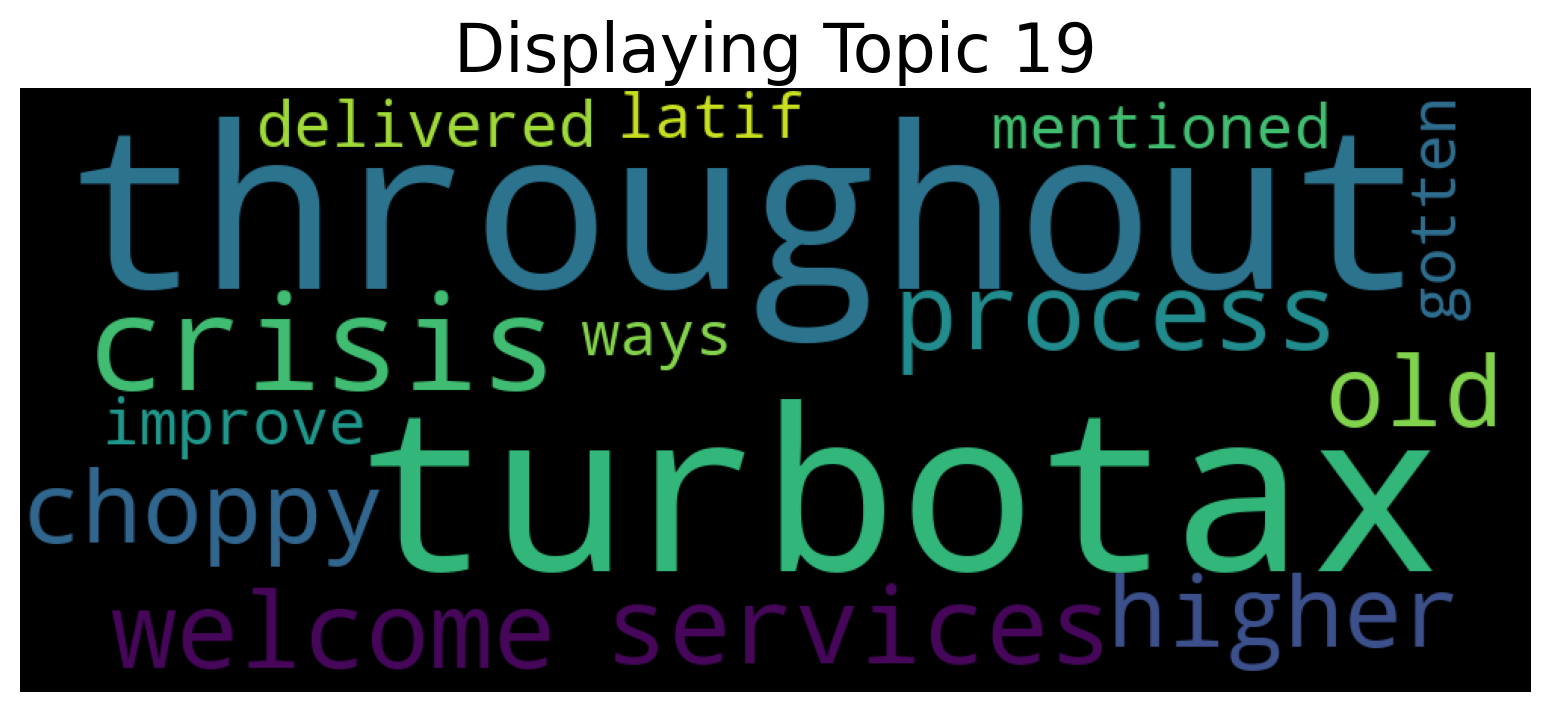

In [19]:
ctm.get_wordcloud(topic_id=19, n_words=15)

## Visualization using pyLDAvis

In [20]:
lda_vis_data = ctm.get_ldavis_data_format(tp.vocab, training_dataset, n_samples=10)

Sampling: [10/10]: : 10it [00:02,  4.79it/s]


In [21]:
import pyLDAvis as vis

lda_vis_data = ctm.get_ldavis_data_format(tp.vocab, training_dataset, n_samples=10)

ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
Sampling: [10/10]: : 10it [00:02,  4.88it/s]
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


## Topic Predictions

In [22]:
topics_predictions = ctm.get_thetas(training_dataset, n_samples=5) # get all the topic predictions

Sampling: [5/5]: : 5it [00:01,  4.75it/s]


In [23]:
preprocessed_documents[0] # see the text of our preprocessed document

'thanks latif good afternoon welcome fourth quarter fiscal conference call ceo sasan goodarzi michelle clatterbuck cfo'

In [24]:
import numpy as np
topic_number = np.argmax(topics_predictions[0]) # get the topic id of the first document

In [25]:
topic_number

13

In [26]:
ctm.get_topic_lists()

[['know',
  'especially',
  'prs',
  'rough',
  'experience',
  'downtime',
  'expect',
  'revolutionize',
  'work',
  'completed'],
 ['general',
  'deploy',
  'really',
  'tracking',
  'better',
  'existing',
  'resiliency',
  'experiencing',
  'earlier',
  'balance'],
 ['gradual',
  'rough',
  'continue',
  'launches',
  'adoption',
  'different',
  'around',
  'fortunate',
  'seeing',
  'know'],
 ['well',
  'disciplined',
  'fallen',
  'finally',
  'yield',
  'bucket',
  'players',
  'absolutely',
  'keeping',
  'internals'],
 ['ago',
  'cash',
  'expand',
  'hire',
  'apparent',
  'longer',
  'back',
  'employees',
  'understanding',
  'bounce'],
 ['experience',
  'crisis',
  'play',
  'platform',
  'tell',
  'expert',
  'meaningful',
  'greater',
  'operate',
  'necessary'],
 ['earlier',
  'strongest',
  'believe',
  'board',
  'customers',
  'michelle',
  'accelerated',
  'pocket',
  'pace',
  'seen'],
 ['several',
  'investments',
  'stakeholders',
  'think',
  'challenge',
  'w

In [27]:
ctm.get_topic_lists(5)[5]

['experience', 'crisis', 'play', 'platform', 'tell']

In [28]:
ctm.get_topic_lists(5)[topic_number] 

['september', 'business', 'desktop', 'monthly', 'approximately']

## ii) Using Finbert Transformer

In [29]:
tp1 = TopicModelDataPreparation("ProsusAI/finbert") # instantiate a contextualized model

# create the training set
training_dataset = tp1.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/758 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/ProsusAI_finbert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 252 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [30]:
tp1.vocab[:10]

['ability',
 'able',
 'absolutely',
 'accelerant',
 'accelerate',
 'accelerated',
 'accelerates',
 'accelerating',
 'acceleration',
 'accept']

In [31]:
tp1.vocab[:]

['ability',
 'able',
 'absolutely',
 'accelerant',
 'accelerate',
 'accelerated',
 'accelerates',
 'accelerating',
 'acceleration',
 'accept',
 'access',
 'accident',
 'accomplished',
 'accomplishments',
 'account',
 'accountants',
 'accounting',
 'accounts',
 'accurate',
 'achieve',
 'achieving',
 'acquisition',
 'acquisitions',
 'across',
 'acting',
 'active',
 'actually',
 'add',
 'added',
 'addition',
 'address',
 'adjust',
 'adoption',
 'advanced',
 'advantages',
 'afternoon',
 'agnostic',
 'ago',
 'ahead',
 'ai',
 'albeit',
 'aligned',
 'allowing',
 'allows',
 'almost',
 'along',
 'also',
 'alternative',
 'although',
 'always',
 'amazon',
 'ambitious',
 'analysis',
 'announced',
 'another',
 'answer',
 'apparent',
 'applications',
 'applies',
 'approach',
 'approved',
 'approximately',
 'apps',
 'april',
 'area',
 'areas',
 'arizona',
 'around',
 'arpc',
 'aside',
 'asked',
 'assisted',
 'associated',
 'assume',
 'assumes',
 'attached',
 'attractive',
 'attrition',
 'authorizatio

#### Training Combined TM

In [32]:
ctm = CombinedTM(bow_size=len(tp1.vocab), contextual_size=768, n_components=10, num_epochs=10)
ctm.fit(training_dataset) # run the model

Epoch: [10/10]	 Seen Samples: [1940/1940]	Train Loss: 179.2075510713243	Time: 0:00:00.301800: : 10it [00:03,  3.28it/s]
Sampling: [20/20]: : 20it [00:04,  4.77it/s]


#### Getting the Topics

In [33]:
ctm.get_topic_lists()

[['group',
  'filings',
  'second',
  'ppp',
  'half',
  'million',
  'within',
  'full',
  'including',
  'shift'],
 ['payroll',
  'small',
  'innovation',
  'bounce',
  'money',
  'future',
  'business',
  'focused',
  'release',
  'cloud'],
 ['therefore',
  'press',
  'resilient',
  'engage',
  'video',
  'hoping',
  'fingertips',
  'pursue',
  'figure',
  'question'],
 ['cash',
  'getting',
  'use',
  'customers',
  'based',
  'two',
  'point',
  'account',
  'may',
  'method'],
 ['without',
  'everyone',
  'revolver',
  'wrap',
  'challenge',
  'happy',
  'expectations',
  'worldwide',
  'problems',
  'revolutionize'],
 ['work',
  'necessary',
  'lot',
  'virtual',
  'bet',
  'tradition',
  'tell',
  'opportunities',
  'modern',
  'drove'],
 ['expert',
  'total',
  'tax',
  'operating',
  'believe',
  'group',
  'grew',
  'income',
  'gaap',
  'focus'],
 ['important',
  'foundational',
  'faster',
  'capital',
  'big',
  'expand',
  'cash',
  'largest',
  'understand',
  'ecosyste

In [34]:
ctm.get_topics()

defaultdict(list,
            {0: ['group',
              'filings',
              'second',
              'ppp',
              'half',
              'million',
              'within',
              'full',
              'including',
              'shift'],
             1: ['payroll',
              'small',
              'innovation',
              'bounce',
              'money',
              'future',
              'business',
              'focused',
              'release',
              'cloud'],
             2: ['therefore',
              'press',
              'resilient',
              'engage',
              'video',
              'hoping',
              'fingertips',
              'pursue',
              'figure',
              'question'],
             3: ['cash',
              'getting',
              'use',
              'customers',
              'based',
              'two',
              'point',
              'account',
              'may',
              'method'],
  

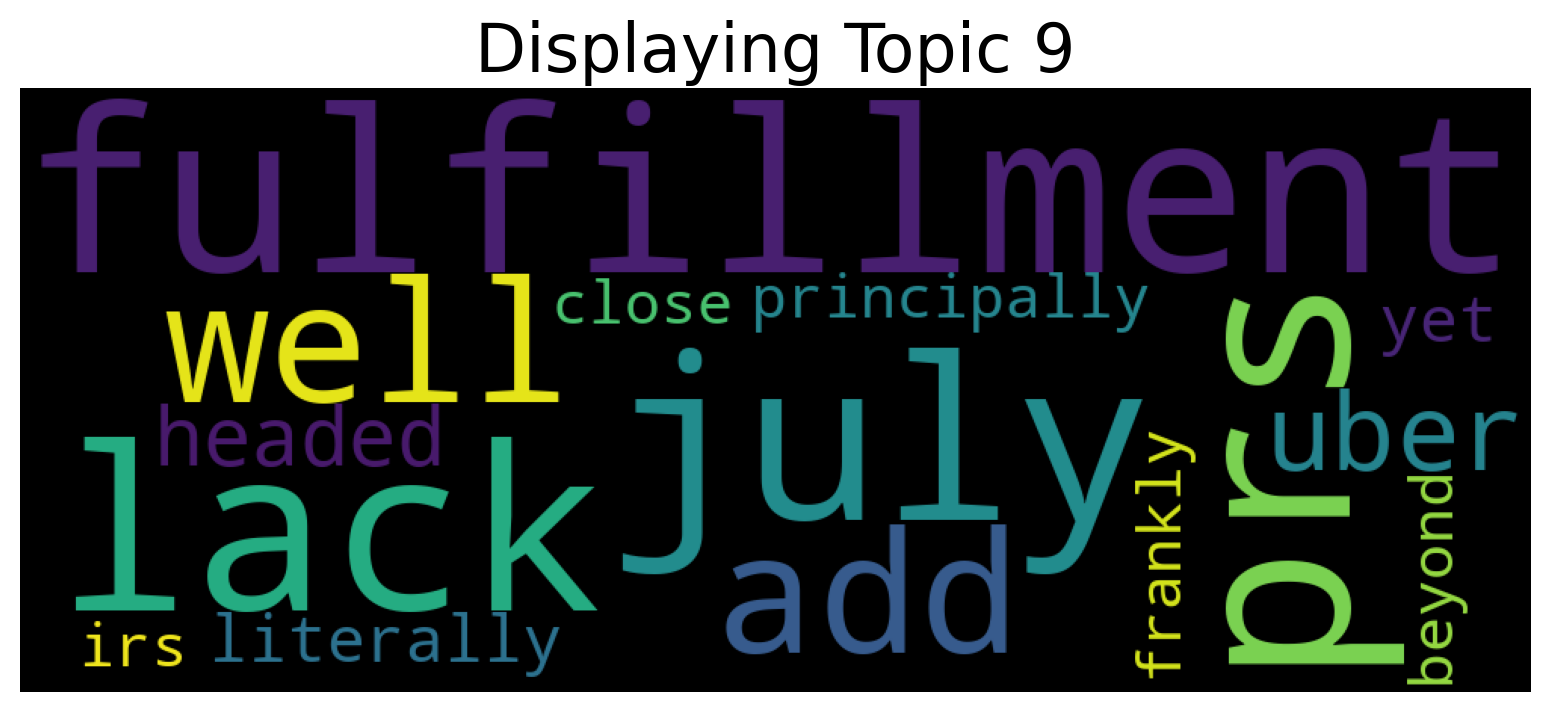

In [35]:
ctm.get_wordcloud(topic_id=9, n_words=15)

#### pyLDAvis for Visualization

In [36]:
lda_vis_data = ctm.get_ldavis_data_format(tp1.vocab, training_dataset, n_samples=10)

Sampling: [10/10]: : 10it [00:02,  4.64it/s]


In [37]:
import pyLDAvis as vis
lda_vis_data = ctm.get_ldavis_data_format(tp1.vocab, training_dataset, n_samples=10)
ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

Sampling: [10/10]: : 10it [00:02,  4.67it/s]
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


#### Topic Predictions

In [38]:
topics_predictions = ctm.get_thetas(training_dataset, n_samples=5) 

Sampling: [5/5]: : 5it [00:01,  4.59it/s]


In [39]:
preprocessed_documents[0] 

'thanks latif good afternoon welcome fourth quarter fiscal conference call ceo sasan goodarzi michelle clatterbuck cfo'

In [40]:
import numpy as np
topic_number = np.argmax(topics_predictions[0]) 

In [41]:
topic_number

9

In [42]:
ctm.get_topic_lists()

[['group',
  'filings',
  'second',
  'ppp',
  'half',
  'million',
  'within',
  'full',
  'including',
  'shift'],
 ['payroll',
  'small',
  'innovation',
  'bounce',
  'money',
  'future',
  'business',
  'focused',
  'release',
  'cloud'],
 ['therefore',
  'press',
  'resilient',
  'engage',
  'video',
  'hoping',
  'fingertips',
  'pursue',
  'figure',
  'question'],
 ['cash',
  'getting',
  'use',
  'customers',
  'based',
  'two',
  'point',
  'account',
  'may',
  'method'],
 ['without',
  'everyone',
  'revolver',
  'wrap',
  'challenge',
  'happy',
  'expectations',
  'worldwide',
  'problems',
  'revolutionize'],
 ['work',
  'necessary',
  'lot',
  'virtual',
  'bet',
  'tradition',
  'tell',
  'opportunities',
  'modern',
  'drove'],
 ['expert',
  'total',
  'tax',
  'operating',
  'believe',
  'group',
  'grew',
  'income',
  'gaap',
  'focus'],
 ['important',
  'foundational',
  'faster',
  'capital',
  'big',
  'expand',
  'cash',
  'largest',
  'understand',
  'ecosyste

In [43]:
ctm.get_topic_lists(5)[5]

['work', 'necessary', 'lot', 'virtual', 'bet']

In [44]:
ctm.get_topic_lists(5)[topic_number] 

['lack', 'fulfillment', 'july', 'prs', 'well']

## iii) Using all-distilroberta-v1 Transformer

In [45]:
tp2 = TopicModelDataPreparation("all-distilroberta-v1") # instantiate a contextualized model

# create the training set
training_dataset = tp2.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/653 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 252 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [46]:
tp2.vocab[:10]

['ability',
 'able',
 'absolutely',
 'accelerant',
 'accelerate',
 'accelerated',
 'accelerates',
 'accelerating',
 'acceleration',
 'accept']

In [47]:
tp2.vocab[:]

['ability',
 'able',
 'absolutely',
 'accelerant',
 'accelerate',
 'accelerated',
 'accelerates',
 'accelerating',
 'acceleration',
 'accept',
 'access',
 'accident',
 'accomplished',
 'accomplishments',
 'account',
 'accountants',
 'accounting',
 'accounts',
 'accurate',
 'achieve',
 'achieving',
 'acquisition',
 'acquisitions',
 'across',
 'acting',
 'active',
 'actually',
 'add',
 'added',
 'addition',
 'address',
 'adjust',
 'adoption',
 'advanced',
 'advantages',
 'afternoon',
 'agnostic',
 'ago',
 'ahead',
 'ai',
 'albeit',
 'aligned',
 'allowing',
 'allows',
 'almost',
 'along',
 'also',
 'alternative',
 'although',
 'always',
 'amazon',
 'ambitious',
 'analysis',
 'announced',
 'another',
 'answer',
 'apparent',
 'applications',
 'applies',
 'approach',
 'approved',
 'approximately',
 'apps',
 'april',
 'area',
 'areas',
 'arizona',
 'around',
 'arpc',
 'aside',
 'asked',
 'assisted',
 'associated',
 'assume',
 'assumes',
 'attached',
 'attractive',
 'attrition',
 'authorizatio

In [48]:
ctm = CombinedTM(bow_size=len(tp2.vocab), contextual_size=768, n_components=20, num_epochs=10)
ctm.fit(training_dataset) # run the model

Epoch: [10/10]	 Seen Samples: [1940/1940]	Train Loss: 191.05299314518564	Time: 0:00:00.315481: : 10it [00:03,  3.00it/s]
Sampling: [20/20]: : 20it [00:07,  2.76it/s]


In [49]:
# Getting the topics
ctm.get_topic_lists(5)

[['connect', 'deployments', 'development', 'win', 'always'],
 ['flow', 'effective', 'reminder', 'businesses', 'chat'],
 ['question', 'yeah', 'five', 'say', 'means'],
 ['experience', 'product', 'ensure', 'relative', 'leverage'],
 ['ever', 'also', 'ability', 'lot', 'ensuring'],
 ['karma', 'repaid', 'priority', 'payrolls', 'corporate'],
 ['manage', 'business', 'cloud', 'one', 'always'],
 ['performance', 'opportunities', 'considering', 'faster', 'resilient'],
 ['use', 'materially', 'pockets', 'customer', 'engage'],
 ['lastly', 'kind', 'objectives', 'philosophy', 'interest'],
 ['matters', 'money', 'accelerant', 'wrap', 'right'],
 ['landscaping', 'result', 'fact', 'free', 'allowing'],
 ['growth', 'quarter', 'excluding', 'group', 'adoption'],
 ['first', 'investments', 'test', 'payments', 'mainly'],
 ['another', 'experiment', 'release', 'turn', 'customers'],
 ['etsy', 'able', 'instagram', 'want', 'one'],
 ['gets', 'account', 'place', 'key', 'terms'],
 ['platform', 'year', 'retention', 'strateg

In [50]:
ctm.get_topics()

defaultdict(list,
            {0: ['connect',
              'deployments',
              'development',
              'win',
              'always',
              'importantly',
              'fraction',
              'accurate',
              'model',
              'area'],
             1: ['flow',
              'effective',
              'reminder',
              'businesses',
              'chat',
              'small',
              'flexible',
              'folks',
              'future',
              'lesser'],
             2: ['question',
              'yeah',
              'five',
              'say',
              'means',
              'accelerates',
              'give',
              'close',
              'acquisitions',
              'actually'],
             3: ['experience',
              'product',
              'ensure',
              'relative',
              'leverage',
              'reminder',
              'third',
              'september',
              'lagg

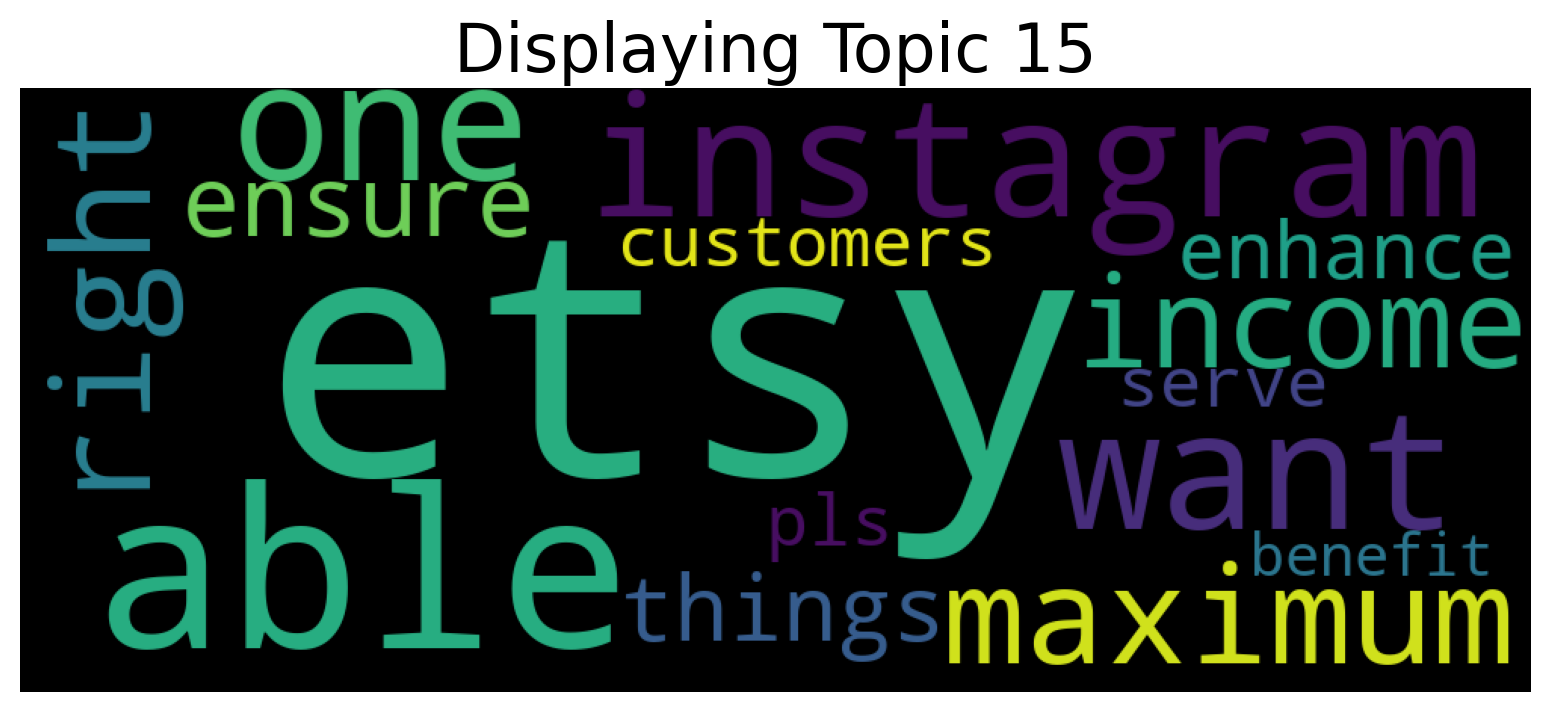

In [51]:
ctm.get_wordcloud(topic_id=15, n_words=15)

In [52]:
# PyLDAvis Visualization
lda_vis_data = ctm.get_ldavis_data_format(tp2.vocab, training_dataset, n_samples=10)

Sampling: [10/10]: : 10it [00:02,  3.90it/s]


In [53]:
import pyLDAvis as vis
lda_vis_data = ctm.get_ldavis_data_format(tp2.vocab, training_dataset, n_samples=10)
ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

Sampling: [10/10]: : 10it [00:02,  4.13it/s]
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [54]:
# Topic predictions
topics_predictions = ctm.get_thetas(training_dataset, n_samples=5)

Sampling: [5/5]: : 5it [00:01,  4.23it/s]


In [55]:
preprocessed_documents[0]

'thanks latif good afternoon welcome fourth quarter fiscal conference call ceo sasan goodarzi michelle clatterbuck cfo'

In [56]:
import numpy as np
topic_number = np.argmax(topics_predictions[0])

In [57]:
topic_number

1

In [58]:
ctm.get_topic_lists()

[['connect',
  'deployments',
  'development',
  'win',
  'always',
  'importantly',
  'fraction',
  'accurate',
  'model',
  'area'],
 ['flow',
  'effective',
  'reminder',
  'businesses',
  'chat',
  'small',
  'flexible',
  'folks',
  'future',
  'lesser'],
 ['question',
  'yeah',
  'five',
  'say',
  'means',
  'accelerates',
  'give',
  'close',
  'acquisitions',
  'actually'],
 ['experience',
  'product',
  'ensure',
  'relative',
  'leverage',
  'reminder',
  'third',
  'september',
  'lagging',
  'largest'],
 ['ever',
  'also',
  'ability',
  'lot',
  'ensuring',
  'access',
  'point',
  'mid',
  'moderated',
  'payroll'],
 ['karma',
  'repaid',
  'priority',
  'payrolls',
  'corporate',
  'prices',
  'notes',
  'deserve',
  'principle',
  'dialed'],
 ['manage',
  'business',
  'cloud',
  'one',
  'always',
  'integrated',
  'desktop',
  'planner',
  'big',
  'particularly'],
 ['performance',
  'opportunities',
  'considering',
  'faster',
  'resilient',
  'management',
  'beyo

In [59]:
ctm.get_topic_lists(5)[5]

['karma', 'repaid', 'priority', 'payrolls', 'corporate']

In [60]:
ctm.get_topic_lists(5)[topic_number]

['flow', 'effective', 'reminder', 'businesses', 'chat']

## iv) Using roberta-base Transformer

In [61]:
tp3 = TopicModelDataPreparation("roberta-base") # instantiate a contextualized model

# create the training set
training_dataset = tp3.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.08k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/603k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 252 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your c

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [62]:
tp3.vocab[:10]

['ability',
 'able',
 'absolutely',
 'accelerant',
 'accelerate',
 'accelerated',
 'accelerates',
 'accelerating',
 'acceleration',
 'accept']

In [63]:
ctm = CombinedTM(bow_size=len(tp3.vocab), contextual_size=768, n_components=5, num_epochs=10)
ctm.fit(training_dataset) # run the model

Epoch: [10/10]	 Seen Samples: [1940/1940]	Train Loss: 176.56109603409914	Time: 0:00:00.297131: : 10it [00:02,  3.35it/s]
Sampling: [20/20]: : 20it [00:04,  4.60it/s]


In [64]:
ctm.get_topic_lists(5)

[['revenue', 'quarter', 'nonrecurring', 'future', 'reflecting'],
 ['biggest', 'take', 'tto', 'disrupt', 'near'],
 ['customer', 'become', 'cash', 'capital', 'buy'],
 ['want', 'product', 'order', 'play', 'mid'],
 ['brad', 'automatically', 'questions', 'statements', 'allows']]

In [65]:
ctm.get_topics()

defaultdict(list,
            {0: ['revenue',
              'quarter',
              'nonrecurring',
              'future',
              'reflecting',
              'shutdowns',
              'increases',
              'grew',
              'ppp',
              'higher'],
             1: ['biggest',
              'take',
              'tto',
              'disrupt',
              'near',
              'sasan',
              'velocity',
              'talk',
              'create',
              'well'],
             2: ['customer',
              'become',
              'cash',
              'capital',
              'buy',
              'funds',
              'set',
              'use',
              'ton',
              'focused'],
             3: ['want',
              'product',
              'order',
              'play',
              'mid',
              'capabilities',
              'businesses',
              'experts',
              'really',
              'advanced'],
      

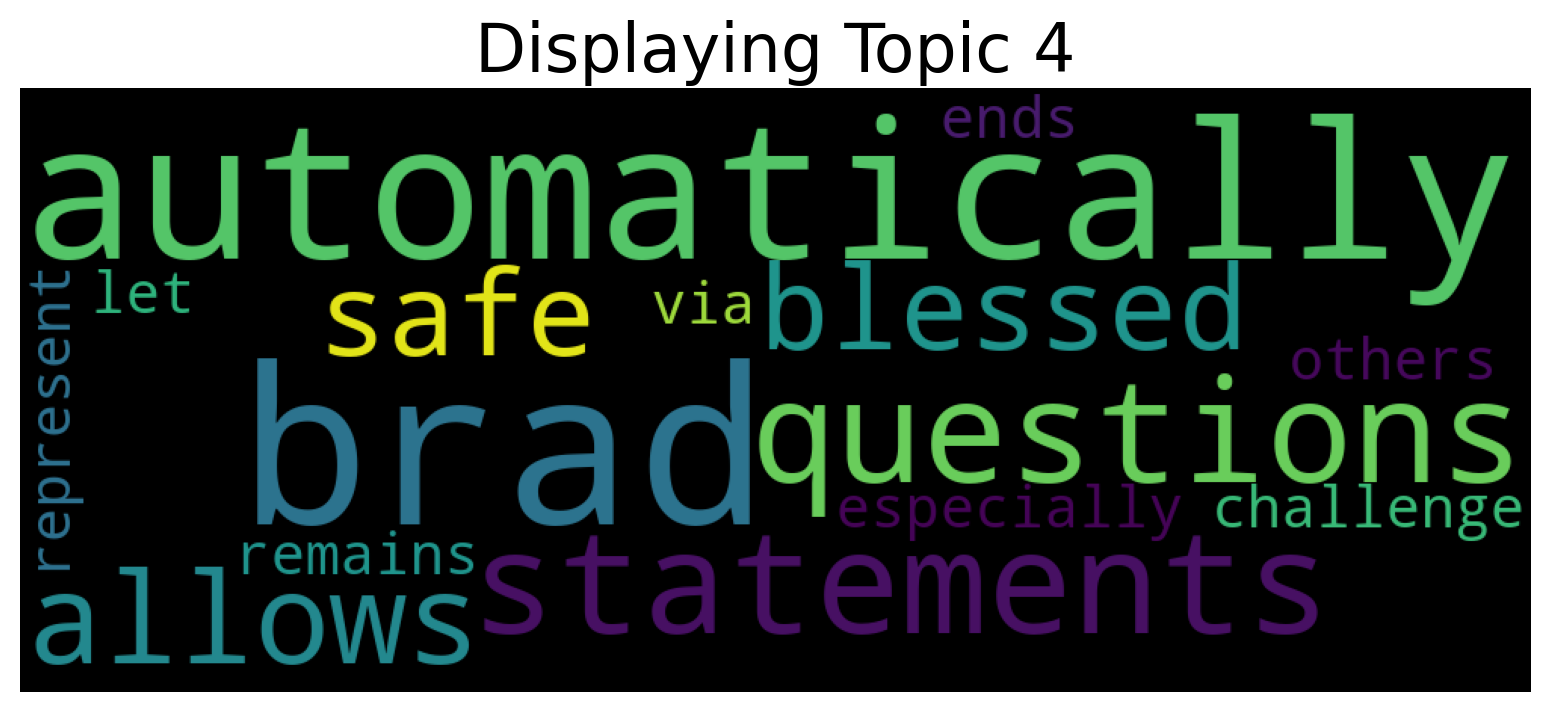

In [66]:
ctm.get_wordcloud(topic_id=4, n_words=15)

In [67]:
# PyLDAvis Visualization
lda_vis_data = ctm.get_ldavis_data_format(tp3.vocab, training_dataset, n_samples=10)

Sampling: [10/10]: : 10it [00:02,  4.53it/s]


In [68]:
import pyLDAvis as vis
lda_vis_data = ctm.get_ldavis_data_format(tp3.vocab, training_dataset, n_samples=10)
ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

Sampling: [10/10]: : 10it [00:02,  4.61it/s]
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [69]:
# Topic predictions
topics_predictions = ctm.get_thetas(training_dataset, n_samples=5) # get all the topic predictions

Sampling: [5/5]: : 5it [00:01,  4.68it/s]


In [70]:
preprocessed_documents[0]

'thanks latif good afternoon welcome fourth quarter fiscal conference call ceo sasan goodarzi michelle clatterbuck cfo'

In [71]:
import numpy as np
topic_number = np.argmax(topics_predictions[0]) 

In [72]:
topic_number

0

In [73]:
ctm.get_topic_lists(5)

[['revenue', 'quarter', 'nonrecurring', 'future', 'reflecting'],
 ['biggest', 'take', 'tto', 'disrupt', 'near'],
 ['customer', 'become', 'cash', 'capital', 'buy'],
 ['want', 'product', 'order', 'play', 'mid'],
 ['brad', 'automatically', 'questions', 'statements', 'allows']]

In [74]:
ctm.get_topic_lists(5)[4]

['brad', 'automatically', 'questions', 'statements', 'allows']

In [75]:
ctm.get_topic_lists(5)[topic_number]

['revenue', 'quarter', 'nonrecurring', 'future', 'reflecting']

## v) Using all-MiniLM-L6-v2 Transformer

In [76]:
tp4 = TopicModelDataPreparation("all-MiniLM-L6-v2") # instantiate a contextualized model

# create the training set
training_dataset = tp4.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 252 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [77]:
tp4.vocab[:10]

['ability',
 'able',
 'absolutely',
 'accelerant',
 'accelerate',
 'accelerated',
 'accelerates',
 'accelerating',
 'acceleration',
 'accept']

In [78]:
tp4.vocab[:]

['ability',
 'able',
 'absolutely',
 'accelerant',
 'accelerate',
 'accelerated',
 'accelerates',
 'accelerating',
 'acceleration',
 'accept',
 'access',
 'accident',
 'accomplished',
 'accomplishments',
 'account',
 'accountants',
 'accounting',
 'accounts',
 'accurate',
 'achieve',
 'achieving',
 'acquisition',
 'acquisitions',
 'across',
 'acting',
 'active',
 'actually',
 'add',
 'added',
 'addition',
 'address',
 'adjust',
 'adoption',
 'advanced',
 'advantages',
 'afternoon',
 'agnostic',
 'ago',
 'ahead',
 'ai',
 'albeit',
 'aligned',
 'allowing',
 'allows',
 'almost',
 'along',
 'also',
 'alternative',
 'although',
 'always',
 'amazon',
 'ambitious',
 'analysis',
 'announced',
 'another',
 'answer',
 'apparent',
 'applications',
 'applies',
 'approach',
 'approved',
 'approximately',
 'apps',
 'april',
 'area',
 'areas',
 'arizona',
 'around',
 'arpc',
 'aside',
 'asked',
 'assisted',
 'associated',
 'assume',
 'assumes',
 'attached',
 'attractive',
 'attrition',
 'authorizatio

In [79]:
ctm = CombinedTM(bow_size=len(tp4.vocab), contextual_size=384, n_components=10, num_epochs=10)
ctm.fit(training_dataset) # run the model

Epoch: [10/10]	 Seen Samples: [1940/1940]	Train Loss: 180.57521953779397	Time: 0:00:00.251096: : 10it [00:02,  3.73it/s]
Sampling: [20/20]: : 20it [00:04,  4.69it/s]


In [80]:
ctm.get_topic_lists(5)

[['stimulus', 'decrease', 'ppp', 'number', 'excluding'],
 ['intuit', 'dividends', 'order', 'around', 'providers'],
 ['help', 'invoicing', 'introduced', 'fields', 'needs'],
 ['together', 'ppp', 'addition', 'question', 'refund'],
 ['current', 'fourth', 'live', 'business', 'margins'],
 ['would', 'lever', 'improving', 'oh', 'smart'],
 ['within', 'need', 'inform', 'something', 'course'],
 ['day', 'tracking', 'focuses', 'driven', 'say'],
 ['welcome', 'sort', 'growing', 'workers', 'goal'],
 ['revenue', 'businesses', 'fiscal', 'employed', 'platform']]

In [81]:
ctm.get_topics()

defaultdict(list,
            {0: ['stimulus',
              'decrease',
              'ppp',
              'number',
              'excluding',
              'clatterbuck',
              'strongest',
              'hope',
              'double',
              'us'],
             1: ['intuit',
              'dividends',
              'order',
              'around',
              'providers',
              'omnichannel',
              'apparent',
              'instant',
              'sure',
              'channels'],
             2: ['help',
              'invoicing',
              'introduced',
              'fields',
              'needs',
              'fifth',
              'decrease',
              'sasan',
              'product',
              'workflow'],
             3: ['together',
              'ppp',
              'addition',
              'question',
              'refund',
              'priorities',
              'tend',
              'provider',
              'launch'

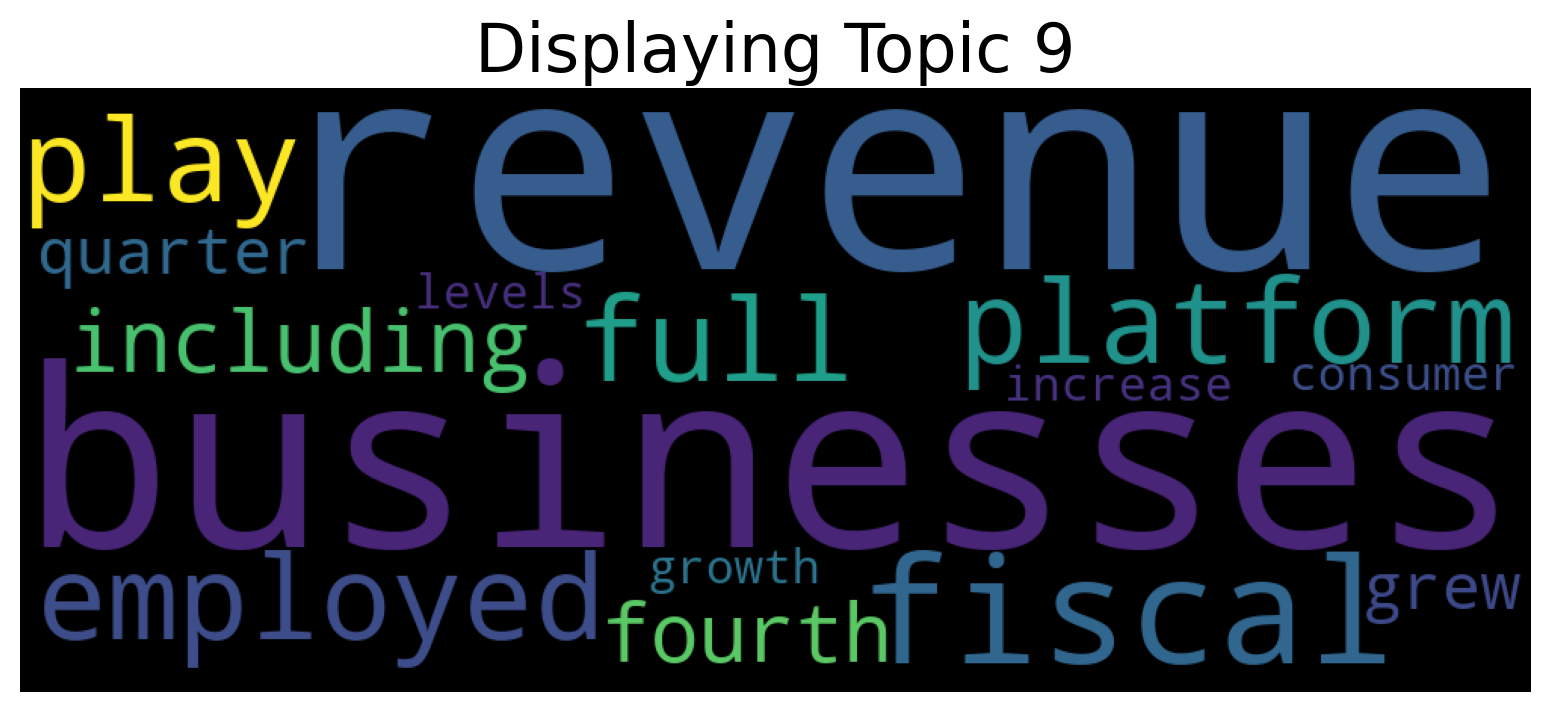

In [82]:
ctm.get_wordcloud(topic_id=9, n_words=15)

In [83]:
# PyLDAvis Visualization
lda_vis_data = ctm.get_ldavis_data_format(tp4.vocab, training_dataset, n_samples=10)

Sampling: [10/10]: : 10it [00:02,  4.66it/s]


In [84]:
import pyLDAvis as vis
lda_vis_data = ctm.get_ldavis_data_format(tp4.vocab, training_dataset, n_samples=10)
ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

Sampling: [10/10]: : 10it [00:02,  4.68it/s]
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [85]:
# Topic predictions
topics_predictions = ctm.get_thetas(training_dataset, n_samples=5) # get all the topic predictions

Sampling: [5/5]: : 5it [00:01,  4.58it/s]


In [86]:
preprocessed_documents[1]

'start like remind everyone remarks include forward looking statements number factors could cause results differ materially expectations'

In [87]:
import numpy as np
topic_number = np.argmax(topics_predictions[1]) 

In [88]:
topic_number

8

In [89]:
ctm.get_topic_lists(5)[5]

['would', 'lever', 'improving', 'oh', 'smart']

In [90]:
ctm.get_topic_lists(5)[topic_number]

['welcome', 'sort', 'growing', 'workers', 'goal']

## vi) Using all-MiniLM-L12-v2 Transformer

In [91]:
tp5 = TopicModelDataPreparation("all-MiniLM-L12-v2") 
training_dataset = tp5.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/573 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/352 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 252 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [92]:
tp5.vocab[:1]

['ability']

In [93]:
tp5.vocab[:9]

['ability',
 'able',
 'absolutely',
 'accelerant',
 'accelerate',
 'accelerated',
 'accelerates',
 'accelerating',
 'acceleration']

In [94]:
ctm = CombinedTM(bow_size=len(tp5.vocab), contextual_size=384, n_components=10, num_epochs=10)
ctm.fit(training_dataset)

Epoch: [10/10]	 Seen Samples: [1940/1940]	Train Loss: 183.27657231596328	Time: 0:00:00.272550: : 10it [00:02,  3.67it/s]
Sampling: [20/20]: : 20it [00:04,  4.68it/s]


In [95]:
ctm.get_topic_lists(5)

[['terms', 'last', 'need', 'start', 'versus'],
 ['increased', 'ecosystem', 'filings', 'focus', 'rates'],
 ['able', 'expert', 'small', 'penalties', 'compliant'],
 ['diluted', 'based', 'tax', 'kind', 'filed'],
 ['friction', 'senior', 'started', 'press', 'monitor'],
 ['shutdowns', 'non', 'passion', 'leverage', 'agnostic'],
 ['new', 'organized', 'brent', 'operate', 'manage'],
 ['cloud', 'way', 'getting', 'question', 'ppp'],
 ['executing', 'forward', 'sense', 'disrupting', 'revenue'],
 ['advanced', 'still', 'assisted', 'quickbooks', 'available']]

In [96]:
ctm.get_topics()

defaultdict(list,
            {0: ['terms',
              'last',
              'need',
              'start',
              'versus',
              'base',
              'seen',
              'learn',
              'jersey',
              'accounting'],
             1: ['increased',
              'ecosystem',
              'filings',
              'focus',
              'rates',
              'product',
              'look',
              'around',
              'even',
              'continue'],
             2: ['able',
              'expert',
              'small',
              'penalties',
              'compliant',
              'make',
              'especially',
              'still',
              'workflow',
              'one'],
             3: ['diluted',
              'based',
              'tax',
              'kind',
              'filed',
              'aside',
              'made',
              'team',
              'score',
              'extended'],
             4: 

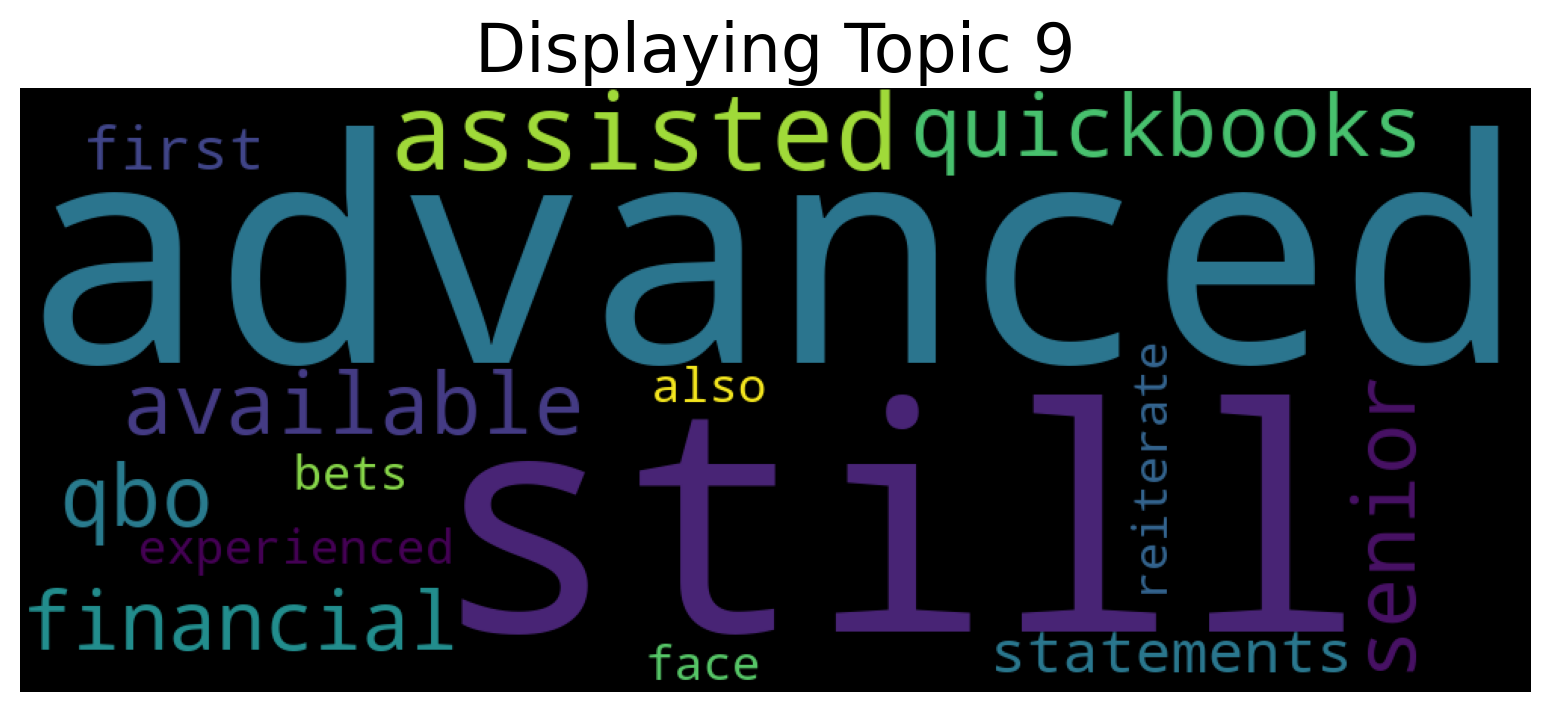

In [97]:
ctm.get_wordcloud(topic_id=9, n_words=15)

In [98]:
# PyLDAvis Visualization
lda_vis_data = ctm.get_ldavis_data_format(tp5.vocab, training_dataset, n_samples=10)

Sampling: [10/10]: : 10it [00:02,  4.60it/s]


In [99]:
import pyLDAvis as vis
lda_vis_data = ctm.get_ldavis_data_format(tp5.vocab, training_dataset, n_samples=10)
ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

Sampling: [10/10]: : 10it [00:02,  4.81it/s]
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [100]:
topics_predictions = ctm.get_thetas(training_dataset, n_samples=5)

Sampling: [5/5]: : 5it [00:01,  4.78it/s]


In [101]:
preprocessed_documents[0] 

'thanks latif good afternoon welcome fourth quarter fiscal conference call ceo sasan goodarzi michelle clatterbuck cfo'

In [102]:
import numpy as np
topic_number = np.argmax(topics_predictions[0])

In [103]:
topic_number

5

In [104]:
ctm.get_topic_lists(5)[5]

['shutdowns', 'non', 'passion', 'leverage', 'agnostic']

In [105]:
ctm.get_topic_lists(5)[topic_number]

['shutdowns', 'non', 'passion', 'leverage', 'agnostic']

# II] Loading the CISCO Dataset

In [106]:
import pickle

with open("cisco/2021Q1/858877_cisco_2021Q1.pickle", "rb") as fp:   
  data = pickle.load(fp)

print(len(data))
print(data)

3
{'transcript': {'Marilyn Mora': ["\nThanks Michelle. Welcome, everyone, to Cisco's first quarter of fiscal 2021 quarterly earnings conference call. This is Marilyn Mora, Head of Investor Relations, and I'm joined by Chuck Robbins, our Chairman and CEO; and Kelly Kramer, our CFO. By now, you should have seen our earnings press release. A corresponding webcast with slides, including supplemental information, will be made available on our website in the Investor Relations section following the call.\nAs is customary, in Q1, we have made certain reclassifications to prior-period amounts to conform to the current period's presentation. Income statements, full GAAP to non-GAAP reconciliation information, balance sheets, cash flow statements and other financial information can also be found in the Financial Information section of our Investor Relations website. Throughout this conference call, we will be referencing both GAAP and non-GAAP financial results and will discuss product results i

In [107]:
print(data['transcript'].keys())
cisco_data = data['transcript']['Marilyn Mora']+data['transcript']['Chuck Robbins']+data['transcript']['Kelly Kramer']

dict_keys(['Marilyn Mora', 'Chuck Robbins', 'Kelly Kramer', 'Ittai Kidron', 'Paul Silverstein', 'Rod Hall', 'Meta Marshall', 'Tim Long', 'Jim Suva', 'Tal Liani', 'Amit Daryanani', 'Samik Chatterjee', 'Aaron Rakers', 'Simon Leopold', 'James Fish', 'Sami Badri', 'Operator'])


## Data Preprocessing

In [108]:
count=0
string_list=[]
for i in cisco_data:
  count = count + len (i.strip().split("\n"))
  string_list+= i.strip().split("\n") 
data_final=[]
for i in string_list:
  if (len(i)>20):
    data_final.append(i)
print(data_final[0])

Thanks Michelle. Welcome, everyone, to Cisco's first quarter of fiscal 2021 quarterly earnings conference call. This is Marilyn Mora, Head of Investor Relations, and I'm joined by Chuck Robbins, our Chairman and CEO; and Kelly Kramer, our CFO. By now, you should have seen our earnings press release. A corresponding webcast with slides, including supplemental information, will be made available on our website in the Investor Relations section following the call.


In [109]:
print(data_final)
print(len(data_final))

["Thanks Michelle. Welcome, everyone, to Cisco's first quarter of fiscal 2021 quarterly earnings conference call. This is Marilyn Mora, Head of Investor Relations, and I'm joined by Chuck Robbins, our Chairman and CEO; and Kelly Kramer, our CFO. By now, you should have seen our earnings press release. A corresponding webcast with slides, including supplemental information, will be made available on our website in the Investor Relations section following the call.", "As is customary, in Q1, we have made certain reclassifications to prior-period amounts to conform to the current period's presentation. Income statements, full GAAP to non-GAAP reconciliation information, balance sheets, cash flow statements and other financial information can also be found in the Financial Information section of our Investor Relations website. Throughout this conference call, we will be referencing both GAAP and non-GAAP financial results and will discuss product results in terms of revenue and geographic 

In [110]:
from nltk.corpus import stopwords as stop_words

nltk.download('stopwords')

stopwords = list(stop_words.words("english"))

sp = WhiteSpacePreprocessingStopwords(data_final, stopwords_list=stopwords)
preprocessed_documents, unpreprocessed_corpus, vocab, retained_indices = sp.preprocess()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [111]:
preprocessed_documents[:1]

['thanks michelle welcome everyone cisco first quarter fiscal quarterly earnings conference call marilyn mora head investor relations joined chuck robbins chairman ceo kelly kramer cfo seen earnings press release corresponding webcast slides including supplemental information made available website investor relations section following call']

### i) all-mpnet-base-v2 Transformer

In [112]:
tp = TopicModelDataPreparation("all-mpnet-base-v2")
training_dataset = tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

/usr/local/lib/python3.7/dist-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 221 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [113]:
tp.vocab[:5]

['aaron', 'accelerate', 'accelerating', 'access', 'accessing']

### Training the Combined TM

In [114]:
ctm = CombinedTM(bow_size=len(tp.vocab), contextual_size=768, n_components=20, num_epochs=10)
ctm.fit(training_dataset) 

Epoch: [10/10]	 Seen Samples: [1550/1550]	Train Loss: 164.55125378024192	Time: 0:00:00.270629: : 10it [00:02,  3.62it/s]
Sampling: [20/20]: : 20it [00:04,  4.87it/s]


In [115]:
ctm.get_topic_lists(10)

[['collaboration',
  'learning',
  'sold',
  'sheet',
  'double',
  'call',
  'driven',
  'participants',
  'productive',
  'webex'],
 ['great',
  'also',
  'differentiated',
  'anywhere',
  'million',
  'federal',
  'margin',
  'please',
  'whatever',
  'bottom'],
 ['revenue',
  'made',
  'address',
  'cares',
  'acquisition',
  'performance',
  'forward',
  'remain',
  'earlier',
  'base'],
 ['employees',
  'solutions',
  'said',
  'response',
  'financial',
  'deploy',
  'individual',
  'accelerate',
  'fiscal',
  'including'],
 ['service',
  'billion',
  'catalyst',
  'deliver',
  'pricing',
  'basis',
  'leading',
  'software',
  'due',
  'duo'],
 ['software',
  'turn',
  'incredible',
  'found',
  'uncertainties',
  'important',
  'sheet',
  'keep',
  'steady',
  'emerging'],
 ['next',
  'americas',
  'lot',
  'commercial',
  'latency',
  'still',
  'calling',
  'support',
  'second',
  'webex'],
 ['primarily',
  'excited',
  'transition',
  'track',
  'enterprises',
  'faster',


In [116]:
ctm.get_topics()

defaultdict(list,
            {0: ['collaboration',
              'learning',
              'sold',
              'sheet',
              'double',
              'call',
              'driven',
              'participants',
              'productive',
              'webex'],
             1: ['great',
              'also',
              'differentiated',
              'anywhere',
              'million',
              'federal',
              'margin',
              'please',
              'whatever',
              'bottom'],
             2: ['revenue',
              'made',
              'address',
              'cares',
              'acquisition',
              'performance',
              'forward',
              'remain',
              'earlier',
              'base'],
             3: ['employees',
              'solutions',
              'said',
              'response',
              'financial',
              'deploy',
              'individual',
              'accelerate',
     

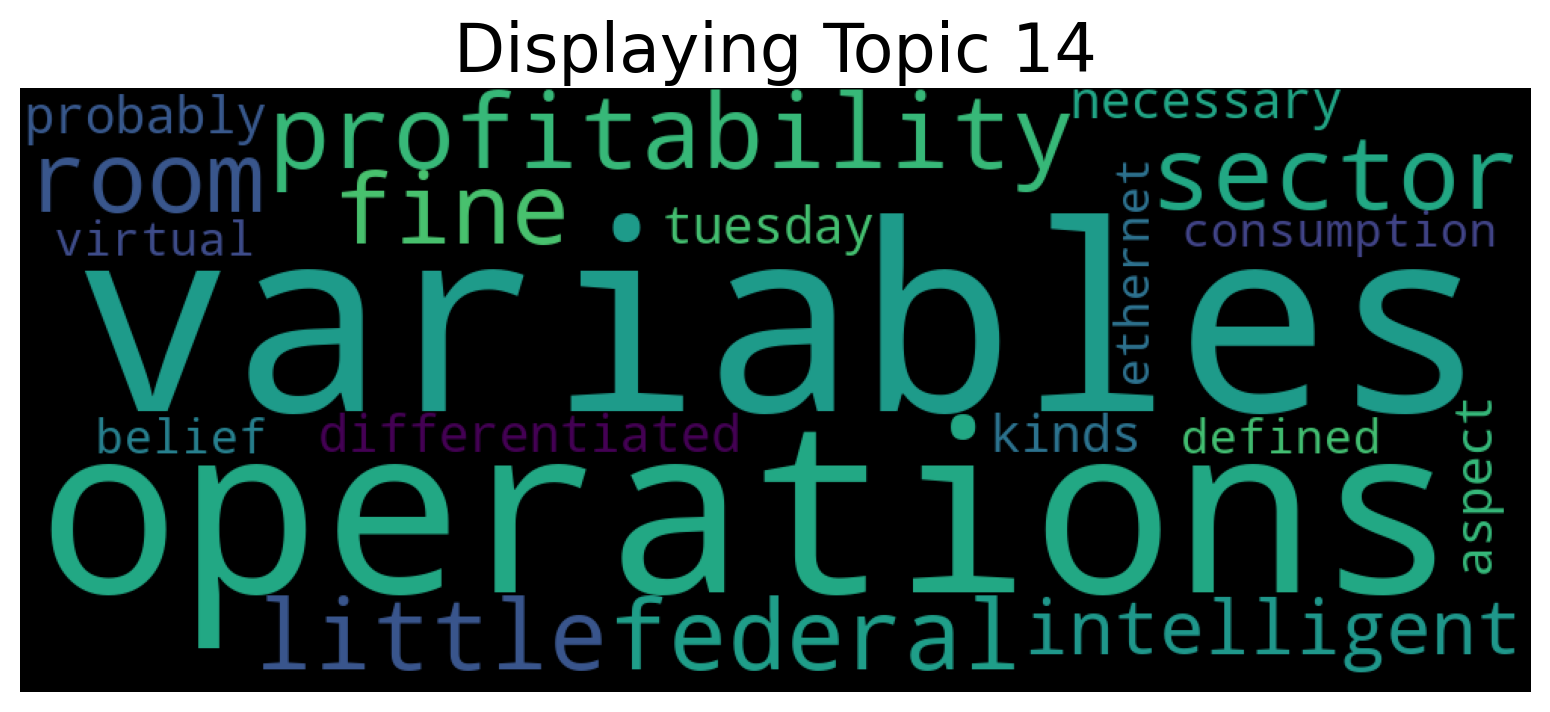

In [117]:
ctm.get_wordcloud(topic_id=14, n_words=20)

### pyLDAvis Visualization

In [118]:
lda_vis_data = ctm.get_ldavis_data_format(tp.vocab, training_dataset, n_samples=10)

Sampling: [10/10]: : 10it [00:02,  4.71it/s]


In [119]:
import pyLDAvis as vis

lda_vis_data = ctm.get_ldavis_data_format(tp.vocab, training_dataset, n_samples=10)

ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

Sampling: [10/10]: : 10it [00:02,  4.79it/s]
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


### Topic Predictions

In [120]:
topics_predictions = ctm.get_thetas(training_dataset, n_samples=5) # get all the topic predictions

Sampling: [5/5]: : 5it [00:00,  5.02it/s]


In [121]:
preprocessed_documents[0]

'thanks michelle welcome everyone cisco first quarter fiscal quarterly earnings conference call marilyn mora head investor relations joined chuck robbins chairman ceo kelly kramer cfo seen earnings press release corresponding webcast slides including supplemental information made available website investor relations section following call'

In [122]:
import numpy as np
topic_number = np.argmax(topics_predictions[0]) # get the topic id of the first document

In [123]:
topic_number

10

In [124]:
ctm.get_topic_lists()

[['collaboration',
  'learning',
  'sold',
  'sheet',
  'double',
  'call',
  'driven',
  'participants',
  'productive',
  'webex'],
 ['great',
  'also',
  'differentiated',
  'anywhere',
  'million',
  'federal',
  'margin',
  'please',
  'whatever',
  'bottom'],
 ['revenue',
  'made',
  'address',
  'cares',
  'acquisition',
  'performance',
  'forward',
  'remain',
  'earlier',
  'base'],
 ['employees',
  'solutions',
  'said',
  'response',
  'financial',
  'deploy',
  'individual',
  'accelerate',
  'fiscal',
  'including'],
 ['service',
  'billion',
  'catalyst',
  'deliver',
  'pricing',
  'basis',
  'leading',
  'software',
  'due',
  'duo'],
 ['software',
  'turn',
  'incredible',
  'found',
  'uncertainties',
  'important',
  'sheet',
  'keep',
  'steady',
  'emerging'],
 ['next',
  'americas',
  'lot',
  'commercial',
  'latency',
  'still',
  'calling',
  'support',
  'second',
  'webex'],
 ['primarily',
  'excited',
  'transition',
  'track',
  'enterprises',
  'faster',


In [125]:
ctm.get_topic_lists(5)[5]

['software', 'turn', 'incredible', 'found', 'uncertainties']

In [126]:
ctm.get_topic_lists(5)[topic_number] 

['going', 'modernizing', 'continue', 'encouraging', 'software']

### ii) Finbert Transformer

In [127]:
tp1 = TopicModelDataPreparation("ProsusAI/finbert")
training_dataset = tp1.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/ProsusAI_finbert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 221 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [128]:
tp1.vocab[:10]

['aaron',
 'accelerate',
 'accelerating',
 'access',
 'accessing',
 'accompany',
 'accounts',
 'acquisition',
 'across',
 'act']

In [129]:
tp1.vocab[:]

['aaron',
 'accelerate',
 'accelerating',
 'access',
 'accessing',
 'accompany',
 'accounts',
 'acquisition',
 'across',
 'act',
 'action',
 'actionable',
 'active',
 'actual',
 'actually',
 'adapt',
 'add',
 'addition',
 'address',
 'adequate',
 'adjusted',
 'administration',
 'adopt',
 'adopters',
 'adopting',
 'adoption',
 'agile',
 'agility',
 'ago',
 'ahead',
 'ai',
 'aligned',
 'allocation',
 'allow',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'always',
 'americas',
 'amount',
 'amounts',
 'analytics',
 'anchors',
 'announced',
 'annualized',
 'another',
 'answer',
 'anticipate',
 'anyconnect',
 'anyone',
 'anything',
 'anywhere',
 'apjc',
 'appdynamics',
 'application',
 'applications',
 'appreciate',
 'architectural',
 'architecture',
 'architectures',
 'area',
 'areas',
 'around',
 'ask',
 'aspect',
 'aspects',
 'assess',
 'assets',
 'assume',
 'attendees',
 'audience',
 'autodesk',
 'automate',
 'automated',
 'automation',
 'available',
 'aws',
 'back',
 'background

In [130]:
#Training the Combined TM
ctm = CombinedTM(bow_size=len(tp1.vocab), contextual_size=768, n_components=10, num_epochs=10)
ctm.fit(training_dataset) # run the model

Epoch: [10/10]	 Seen Samples: [1550/1550]	Train Loss: 154.87640814012096	Time: 0:00:00.252359: : 10it [00:02,  3.69it/s]
Sampling: [20/20]: : 20it [00:04,  4.91it/s]


In [131]:
# Getting the topics
ctm.get_topic_lists()

[['accessing',
  'automation',
  'trusted',
  'regarding',
  'look',
  'networking',
  'head',
  'ph',
  'mid',
  'onramp'],
 ['securely',
  'bigger',
  'still',
  'turn',
  'move',
  'cash',
  'longer',
  'functions',
  'really',
  'information'],
 ['choice',
  'followed',
  'running',
  'campus',
  'key',
  'reasonably',
  'looks',
  'see',
  'pm',
  'transactions'],
 ['video',
  'every',
  'good',
  'dedication',
  'million',
  'last',
  'years',
  'device',
  'audience',
  'many'],
 ['significant',
  'leading',
  'us',
  'secure',
  'new',
  'exposure',
  'double',
  'revenue',
  'number',
  'extended'],
 ['year',
  'product',
  'total',
  'gross',
  'points',
  'ago',
  'sure',
  'list',
  'earnest',
  'sort'],
 ['services',
  'experiences',
  'news',
  'stay',
  'uncertainties',
  'connectivity',
  'backlog',
  'duo',
  'nearly',
  'germany'],
 ['access',
  'hit',
  'say',
  'vertical',
  'offers',
  'strategy',
  'buying',
  'recent',
  'last',
  'success'],
 ['perspective',
  '

In [132]:
ctm.get_topics()

defaultdict(list,
            {0: ['accessing',
              'automation',
              'trusted',
              'regarding',
              'look',
              'networking',
              'head',
              'ph',
              'mid',
              'onramp'],
             1: ['securely',
              'bigger',
              'still',
              'turn',
              'move',
              'cash',
              'longer',
              'functions',
              'really',
              'information'],
             2: ['choice',
              'followed',
              'running',
              'campus',
              'key',
              'reasonably',
              'looks',
              'see',
              'pm',
              'transactions'],
             3: ['video',
              'every',
              'good',
              'dedication',
              'million',
              'last',
              'years',
              'device',
              'audience',
              'many'],

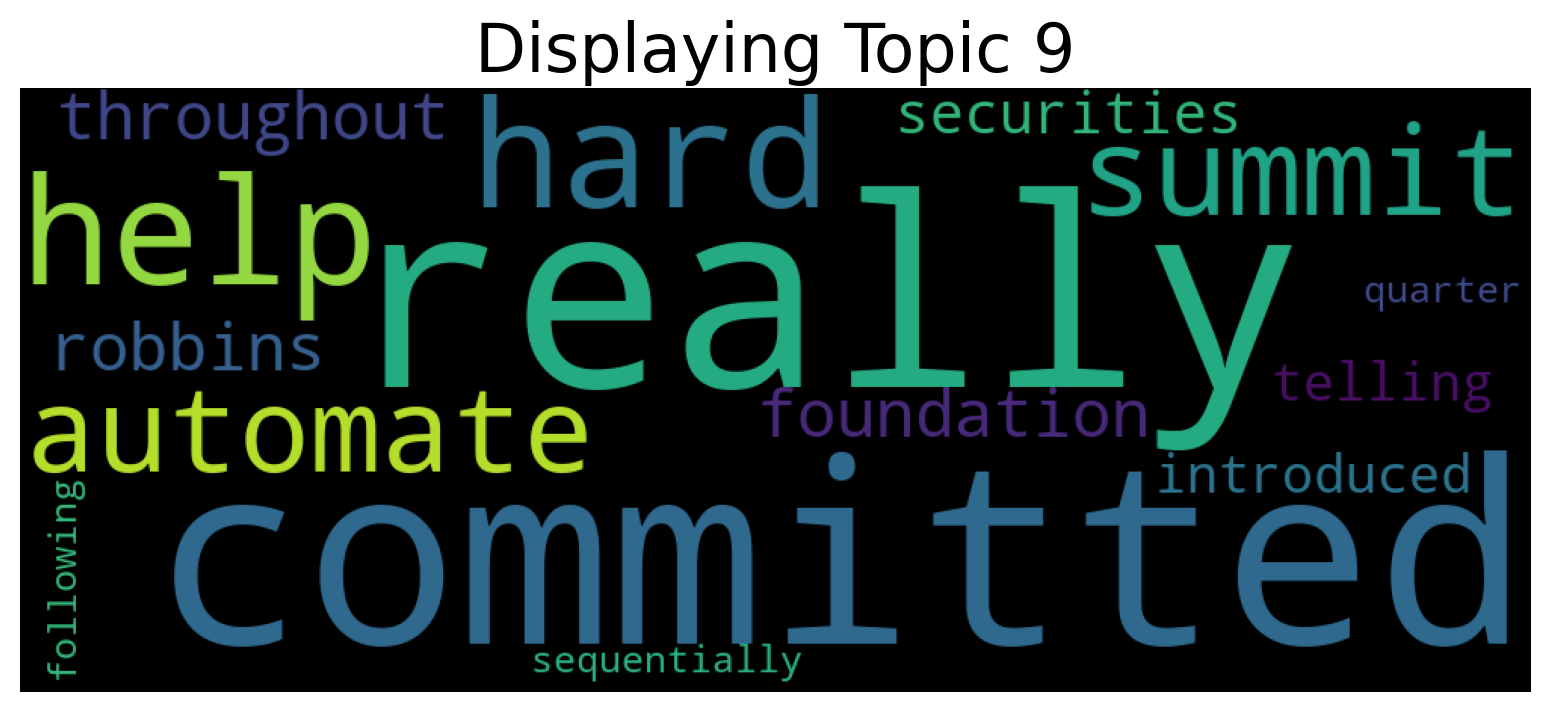

In [133]:
ctm.get_wordcloud(topic_id=9, n_words=15)

In [134]:
# pyLDAvis 
lda_vis_data = ctm.get_ldavis_data_format(tp1.vocab, training_dataset, n_samples=10)
import pyLDAvis as vis
lda_vis_data = ctm.get_ldavis_data_format(tp1.vocab, training_dataset, n_samples=10)
ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

Sampling: [10/10]: : 10it [00:02,  4.80it/s]
Sampling: [10/10]: : 10it [00:02,  4.89it/s]
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [135]:
# Topic Predictions
topics_predictions = ctm.get_thetas(training_dataset, n_samples=5) 
preprocessed_documents[0] 

Sampling: [5/5]: : 5it [00:01,  4.89it/s]


'thanks michelle welcome everyone cisco first quarter fiscal quarterly earnings conference call marilyn mora head investor relations joined chuck robbins chairman ceo kelly kramer cfo seen earnings press release corresponding webcast slides including supplemental information made available website investor relations section following call'

In [136]:
import numpy as np
topic_number = np.argmax(topics_predictions[0]) 
print(topic_number)

1


In [137]:
ctm.get_topic_lists()

[['accessing',
  'automation',
  'trusted',
  'regarding',
  'look',
  'networking',
  'head',
  'ph',
  'mid',
  'onramp'],
 ['securely',
  'bigger',
  'still',
  'turn',
  'move',
  'cash',
  'longer',
  'functions',
  'really',
  'information'],
 ['choice',
  'followed',
  'running',
  'campus',
  'key',
  'reasonably',
  'looks',
  'see',
  'pm',
  'transactions'],
 ['video',
  'every',
  'good',
  'dedication',
  'million',
  'last',
  'years',
  'device',
  'audience',
  'many'],
 ['significant',
  'leading',
  'us',
  'secure',
  'new',
  'exposure',
  'double',
  'revenue',
  'number',
  'extended'],
 ['year',
  'product',
  'total',
  'gross',
  'points',
  'ago',
  'sure',
  'list',
  'earnest',
  'sort'],
 ['services',
  'experiences',
  'news',
  'stay',
  'uncertainties',
  'connectivity',
  'backlog',
  'duo',
  'nearly',
  'germany'],
 ['access',
  'hit',
  'say',
  'vertical',
  'offers',
  'strategy',
  'buying',
  'recent',
  'last',
  'success'],
 ['perspective',
  '

In [138]:
ctm.get_topic_lists(5)[5]

['year', 'product', 'total', 'gross', 'points']

In [139]:
ctm.get_topic_lists(5)[topic_number] 

['securely', 'bigger', 'still', 'turn', 'move']

### iii) all-distilroberta-v1 Transformer

In [140]:
tp2 = TopicModelDataPreparation("all-distilroberta-v1") # instantiate a contextualized model

# create the training set
training_dataset = tp2.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

/usr/local/lib/python3.7/dist-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 221 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [141]:
tp2.vocab[:10]

['aaron',
 'accelerate',
 'accelerating',
 'access',
 'accessing',
 'accompany',
 'accounts',
 'acquisition',
 'across',
 'act']

In [142]:
ctm = CombinedTM(bow_size=len(tp2.vocab), contextual_size=768, n_components=20, num_epochs=10)
ctm.fit(training_dataset) # run the model

Epoch: [10/10]	 Seen Samples: [1550/1550]	Train Loss: 164.3032746345766	Time: 0:00:00.260221: : 10it [00:02,  3.71it/s]
Sampling: [20/20]: : 20it [00:04,  4.80it/s]


In [143]:
# Getting the topics
ctm.get_topic_lists(10)

[['sensors',
  'technologies',
  'workplace',
  'demonstrates',
  'application',
  'closely',
  'solution',
  'strides',
  'shifts',
  'stay'],
 ['going',
  'see',
  'transition',
  'summer',
  'kind',
  'say',
  'happy',
  'growth',
  'products',
  'portfolio'],
 ['key',
  'future',
  'ever',
  'developers',
  'use',
  'talking',
  'impacts',
  'core',
  'healthcare',
  'start'],
 ['everybody',
  'software',
  'enterprise',
  'gateway',
  'balance',
  'improvement',
  'looking',
  'growing',
  'emerging',
  'optimistic'],
 ['fy',
  'speed',
  'congratulate',
  'tell',
  'needs',
  'mix',
  'helpful',
  'slightly',
  'developers',
  'midst'],
 ['technologies',
  'integrated',
  'expertise',
  'deliver',
  'shareholders',
  'sorry',
  'privacy',
  'profitable',
  'income',
  'investments'],
 ['saas',
  'efforts',
  'due',
  'gateway',
  'anyone',
  'employees',
  'students',
  'intellectual',
  'commercial',
  'tal'],
 ['cloud',
  'offices',
  'continued',
  'move',
  'side',
  'ports',

In [144]:
ctm.get_topics()

defaultdict(list,
            {0: ['sensors',
              'technologies',
              'workplace',
              'demonstrates',
              'application',
              'closely',
              'solution',
              'strides',
              'shifts',
              'stay'],
             1: ['going',
              'see',
              'transition',
              'summer',
              'kind',
              'say',
              'happy',
              'growth',
              'products',
              'portfolio'],
             2: ['key',
              'future',
              'ever',
              'developers',
              'use',
              'talking',
              'impacts',
              'core',
              'healthcare',
              'start'],
             3: ['everybody',
              'software',
              'enterprise',
              'gateway',
              'balance',
              'improvement',
              'looking',
              'growing',
              'e

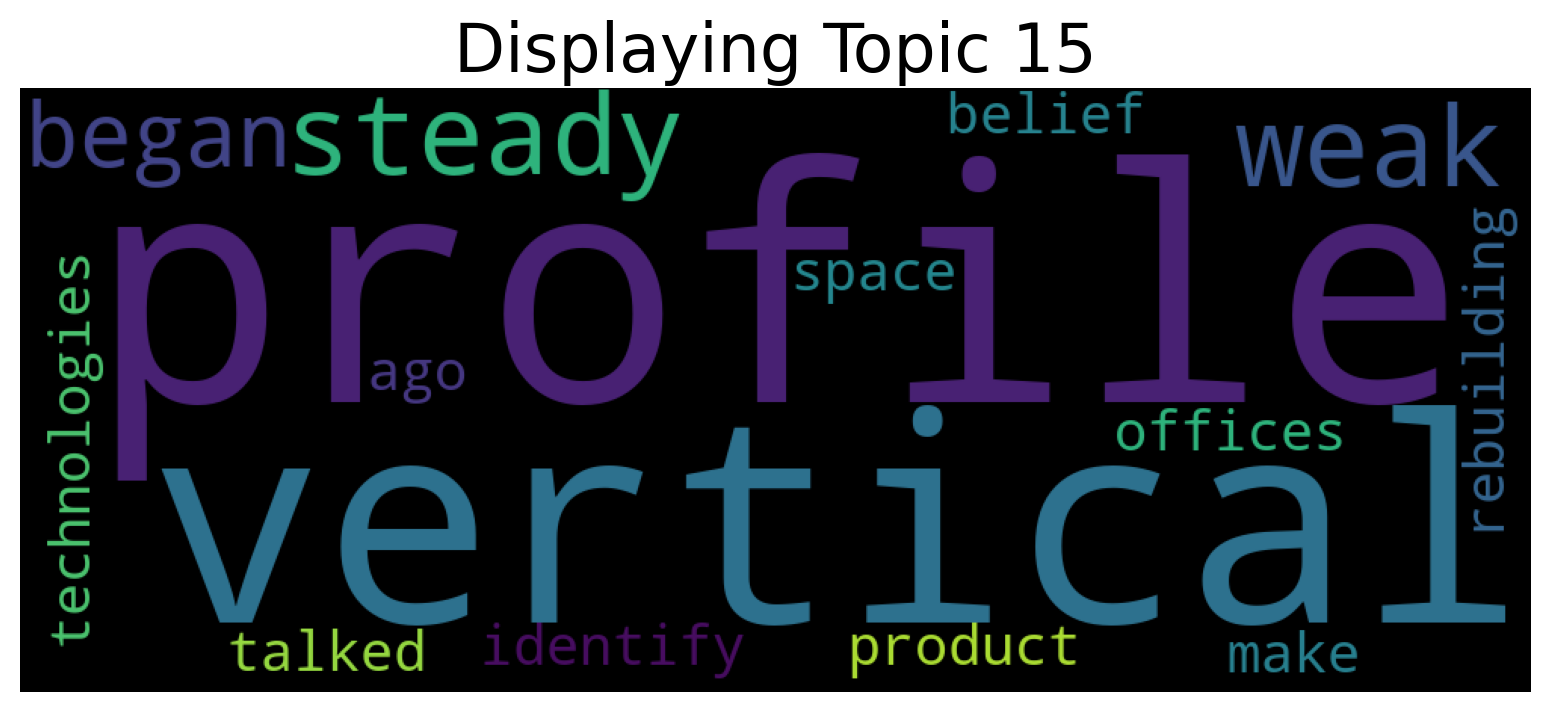

In [145]:
ctm.get_wordcloud(topic_id=15, n_words=15)

In [146]:
# PyLDAvis Visualization
lda_vis_data = ctm.get_ldavis_data_format(tp2.vocab, training_dataset, n_samples=10)
import pyLDAvis as vis
lda_vis_data = ctm.get_ldavis_data_format(tp2.vocab, training_dataset, n_samples=10)
ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

Sampling: [10/10]: : 10it [00:02,  4.76it/s]
Sampling: [10/10]: : 10it [00:02,  4.73it/s]
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [147]:
# Topic predictions
topics_predictions = ctm.get_thetas(training_dataset, n_samples=5)
preprocessed_documents[0]

Sampling: [5/5]: : 5it [00:01,  4.66it/s]


'thanks michelle welcome everyone cisco first quarter fiscal quarterly earnings conference call marilyn mora head investor relations joined chuck robbins chairman ceo kelly kramer cfo seen earnings press release corresponding webcast slides including supplemental information made available website investor relations section following call'

In [148]:
import numpy as np
topic_number = np.argmax(topics_predictions[0])
print(topic_number)

11


In [149]:
ctm.get_topic_lists()

[['sensors',
  'technologies',
  'workplace',
  'demonstrates',
  'application',
  'closely',
  'solution',
  'strides',
  'shifts',
  'stay'],
 ['going',
  'see',
  'transition',
  'summer',
  'kind',
  'say',
  'happy',
  'growth',
  'products',
  'portfolio'],
 ['key',
  'future',
  'ever',
  'developers',
  'use',
  'talking',
  'impacts',
  'core',
  'healthcare',
  'start'],
 ['everybody',
  'software',
  'enterprise',
  'gateway',
  'balance',
  'improvement',
  'looking',
  'growing',
  'emerging',
  'optimistic'],
 ['fy',
  'speed',
  'congratulate',
  'tell',
  'needs',
  'mix',
  'helpful',
  'slightly',
  'developers',
  'midst'],
 ['technologies',
  'integrated',
  'expertise',
  'deliver',
  'shareholders',
  'sorry',
  'privacy',
  'profitable',
  'income',
  'investments'],
 ['saas',
  'efforts',
  'due',
  'gateway',
  'anyone',
  'employees',
  'students',
  'intellectual',
  'commercial',
  'tal'],
 ['cloud',
  'offices',
  'continued',
  'move',
  'side',
  'ports',

In [150]:
ctm.get_topic_lists(4)[1]

['going', 'see', 'transition', 'summer']

In [151]:
ctm.get_topic_lists(5)[topic_number]

['call', 'pandemic', 'internal', 'last', 'weeks']

### iv) roberta-base Transformer

In [152]:
tp3 = TopicModelDataPreparation("roberta-base") # instantiate a contextualized model

# create the training set
training_dataset = tp3.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 221 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your c

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [153]:
tp3.vocab[:4]

['aaron', 'accelerate', 'accelerating', 'access']

In [154]:
ctm = CombinedTM(bow_size=len(tp3.vocab), contextual_size=768, n_components=5, num_epochs=10)
ctm.fit(training_dataset) # run the model

Epoch: [10/10]	 Seen Samples: [1550/1550]	Train Loss: 150.3946793094758	Time: 0:00:00.271170: : 10it [00:02,  3.45it/s]
Sampling: [20/20]: : 20it [00:04,  4.55it/s]


In [155]:
ctm.get_topic_lists(5)

[['leading', 'security', 'billion', 'trust', 'applications'],
 ['individual', 'corresponding', 'compressing', 'tbd', 'clarify'],
 ['get', 'students', 'controls', 'leader', 'improve'],
 ['portfolio', 'non', 'fact', 'time', 'security'],
 ['please', 'gaap', 'cash', 'tax', 'pricing']]

In [156]:
ctm.get_topics()

defaultdict(list,
            {0: ['leading',
              'security',
              'billion',
              'trust',
              'applications',
              'non',
              'times',
              'kelly',
              'user',
              'growth'],
             1: ['individual',
              'corresponding',
              'compressing',
              'tbd',
              'clarify',
              'guys',
              'profile',
              'commitment',
              'refresh',
              'brings'],
             2: ['get',
              'students',
              'controls',
              'leader',
              'improve',
              'middle',
              'packet',
              'employees',
              'differ',
              'reimagining'],
             3: ['portfolio',
              'non',
              'fact',
              'time',
              'security',
              'terms',
              'stimulus',
              'pretty',
              'think',
   

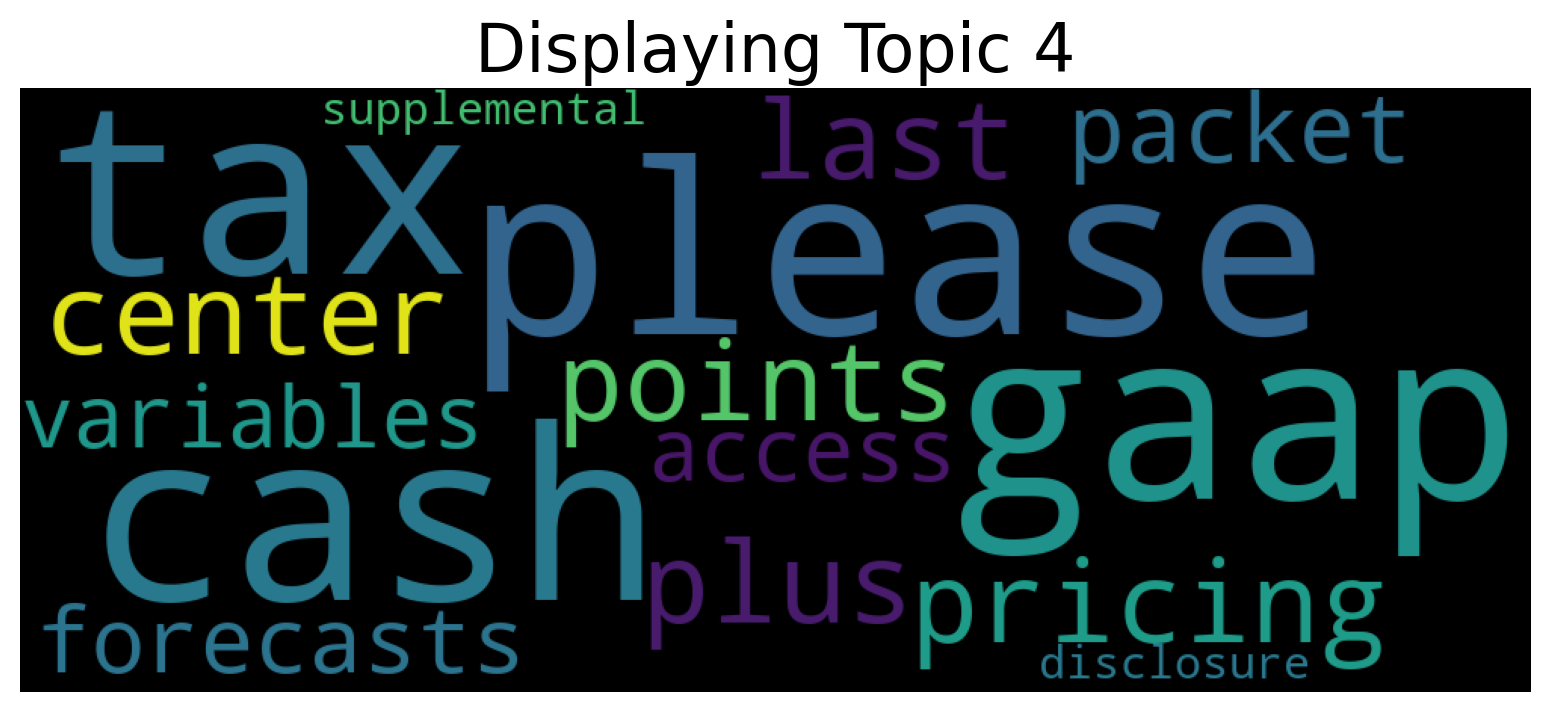

In [157]:
ctm.get_wordcloud(topic_id=4, n_words=15)

In [158]:
# PyLDAvis Visualization
lda_vis_data = ctm.get_ldavis_data_format(tp3.vocab, training_dataset, n_samples=10)
import pyLDAvis as vis
lda_vis_data = ctm.get_ldavis_data_format(tp3.vocab, training_dataset, n_samples=10)
ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

Sampling: [10/10]: : 10it [00:02,  4.57it/s]
Sampling: [10/10]: : 10it [00:02,  4.50it/s]
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [159]:
# Topic predictions
topics_predictions = ctm.get_thetas(training_dataset, n_samples=5) 
preprocessed_documents[0]

Sampling: [5/5]: : 5it [00:01,  4.53it/s]


'thanks michelle welcome everyone cisco first quarter fiscal quarterly earnings conference call marilyn mora head investor relations joined chuck robbins chairman ceo kelly kramer cfo seen earnings press release corresponding webcast slides including supplemental information made available website investor relations section following call'

In [160]:
import numpy as np
topic_number = np.argmax(topics_predictions[0]) 
print(topic_number)

3


In [161]:
ctm.get_topic_lists(5)

[['leading', 'security', 'billion', 'trust', 'applications'],
 ['individual', 'corresponding', 'compressing', 'tbd', 'clarify'],
 ['get', 'students', 'controls', 'leader', 'improve'],
 ['portfolio', 'non', 'fact', 'time', 'security'],
 ['please', 'gaap', 'cash', 'tax', 'pricing']]

In [162]:
ctm.get_topic_lists(1)[2]

['get']

In [163]:
ctm.get_topic_lists(1)[topic_number]

['portfolio']

### v) all-MiniLM-L6-v2 Transformer

In [164]:
tp4 = TopicModelDataPreparation("all-MiniLM-L6-v2") # instantiate a contextualized model

# create the training set
training_dataset = tp4.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

/usr/local/lib/python3.7/dist-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 221 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [165]:
tp4.vocab[:2]

['aaron', 'accelerate']

In [166]:
tp4.vocab[:]

['aaron',
 'accelerate',
 'accelerating',
 'access',
 'accessing',
 'accompany',
 'accounts',
 'acquisition',
 'across',
 'act',
 'action',
 'actionable',
 'active',
 'actual',
 'actually',
 'adapt',
 'add',
 'addition',
 'address',
 'adequate',
 'adjusted',
 'administration',
 'adopt',
 'adopters',
 'adopting',
 'adoption',
 'agile',
 'agility',
 'ago',
 'ahead',
 'ai',
 'aligned',
 'allocation',
 'allow',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'always',
 'americas',
 'amount',
 'amounts',
 'analytics',
 'anchors',
 'announced',
 'annualized',
 'another',
 'answer',
 'anticipate',
 'anyconnect',
 'anyone',
 'anything',
 'anywhere',
 'apjc',
 'appdynamics',
 'application',
 'applications',
 'appreciate',
 'architectural',
 'architecture',
 'architectures',
 'area',
 'areas',
 'around',
 'ask',
 'aspect',
 'aspects',
 'assess',
 'assets',
 'assume',
 'attendees',
 'audience',
 'autodesk',
 'automate',
 'automated',
 'automation',
 'available',
 'aws',
 'back',
 'background

In [167]:
ctm = CombinedTM(bow_size=len(tp4.vocab), contextual_size=384, n_components=10, num_epochs=10)
ctm.fit(training_dataset) # run the model

Epoch: [10/10]	 Seen Samples: [1550/1550]	Train Loss: 155.8167464717742	Time: 0:00:00.239717: : 10it [00:02,  3.75it/s]
Sampling: [20/20]: : 20it [00:04,  4.57it/s]


In [168]:
ctm.get_topic_lists(5)

[['still', 'portfolio', 'telling', 'announced', 'felt'],
 ['double', 'end', 'infrastructure', 'driven', 'identify'],
 ['throughout', 'portfolio', 'identify', 'greater', 'connect'],
 ['brings', 'cisco', 'aspects', 'flexible', 'room'],
 ['architecture', 'execution', 'building', 'relative', 'digital'],
 ['wins', 'sort', 'probably', 'get', 'core'],
 ['subject', 'referred', 'intelligent', 'entire', 'offset'],
 ['call', 'markets', 'thanks', 'headquarters', 'service'],
 ['backhaul', 'entire', 'access', 'appreciate', 'intellectual'],
 ['kelly', 'strength', 'sector', 'lot', 'good']]

In [169]:
ctm.get_topics()

defaultdict(list,
            {0: ['still',
              'portfolio',
              'telling',
              'announced',
              'felt',
              'given',
              'orchestration',
              'identify',
              'world',
              'aspects'],
             1: ['double',
              'end',
              'infrastructure',
              'driven',
              'identify',
              'detail',
              'operate',
              'details',
              'platforms',
              'kelly'],
             2: ['throughout',
              'portfolio',
              'identify',
              'greater',
              'connect',
              'would',
              'conform',
              'dram',
              'business',
              'announced'],
             3: ['brings',
              'cisco',
              'aspects',
              'flexible',
              'room',
              'need',
              'earlier',
              'wi',
              'tuesday'

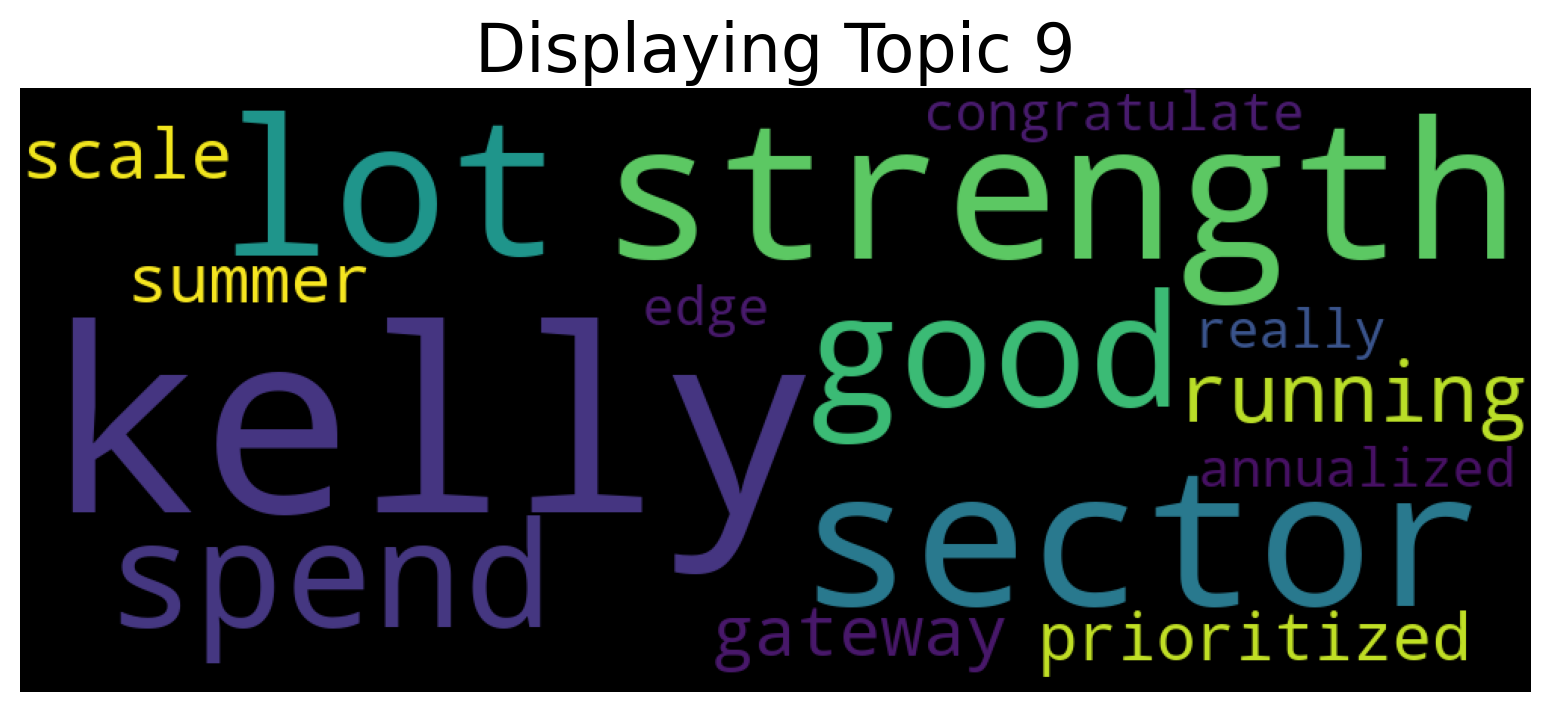

In [170]:
ctm.get_wordcloud(topic_id=9, n_words=15)

In [171]:
# PyLDAvis Visualization
lda_vis_data = ctm.get_ldavis_data_format(tp4.vocab, training_dataset, n_samples=10)
import pyLDAvis as vis
lda_vis_data = ctm.get_ldavis_data_format(tp4.vocab, training_dataset, n_samples=10)
ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

Sampling: [10/10]: : 10it [00:02,  4.62it/s]
Sampling: [10/10]: : 10it [00:02,  4.57it/s]
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [172]:
# Topic predictions
topics_predictions = ctm.get_thetas(training_dataset, n_samples=5) # get all the topic predictions

Sampling: [5/5]: : 5it [00:01,  4.51it/s]


In [173]:
preprocessed_documents[1]

'customary made certain reclassifications prior period amounts conform current period presentation income statements full gaap non gaap reconciliation information balance sheets cash flow statements financial information also found financial information section investor relations website throughout conference call referencing gaap non gaap financial results discuss product results terms revenue geographic customer results terms product orders unless stated otherwise comparisons made throughout call year year basis matters discussing today include forward looking statements including guidance providing second quarter fiscal subject risks uncertainties including covid discuss detail documents filed sec specifically recent report form identify important risk factors could cause actual results differ materially contained forward looking statements respect guidance please also see slides press release accompany call details cisco comment financial guidance quarter unless done explicit publi

In [174]:
import numpy as np
topic_number = np.argmax(topics_predictions[1]) 
print(topic_number)

7


In [175]:
ctm.get_topic_lists(1)[1]

['double']

In [176]:
ctm.get_topic_lists(1)[topic_number]

['call']

### vi) all-MiniLM-L12-v2 Transformer

In [177]:
tp5 = TopicModelDataPreparation("all-MiniLM-L12-v2") 
training_dataset = tp5.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

/usr/local/lib/python3.7/dist-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 221 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [178]:
tp5.vocab[:1]

['aaron']

In [179]:
tp5.vocab[:]

['aaron',
 'accelerate',
 'accelerating',
 'access',
 'accessing',
 'accompany',
 'accounts',
 'acquisition',
 'across',
 'act',
 'action',
 'actionable',
 'active',
 'actual',
 'actually',
 'adapt',
 'add',
 'addition',
 'address',
 'adequate',
 'adjusted',
 'administration',
 'adopt',
 'adopters',
 'adopting',
 'adoption',
 'agile',
 'agility',
 'ago',
 'ahead',
 'ai',
 'aligned',
 'allocation',
 'allow',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'always',
 'americas',
 'amount',
 'amounts',
 'analytics',
 'anchors',
 'announced',
 'annualized',
 'another',
 'answer',
 'anticipate',
 'anyconnect',
 'anyone',
 'anything',
 'anywhere',
 'apjc',
 'appdynamics',
 'application',
 'applications',
 'appreciate',
 'architectural',
 'architecture',
 'architectures',
 'area',
 'areas',
 'around',
 'ask',
 'aspect',
 'aspects',
 'assess',
 'assets',
 'assume',
 'attendees',
 'audience',
 'autodesk',
 'automate',
 'automated',
 'automation',
 'available',
 'aws',
 'back',
 'background

In [180]:
ctm = CombinedTM(bow_size=len(tp5.vocab), contextual_size=384, n_components=10, num_epochs=10)
ctm.fit(training_dataset)

Epoch: [10/10]	 Seen Samples: [1550/1550]	Train Loss: 158.11914377520162	Time: 0:00:00.249953: : 10it [00:02,  3.80it/s]
Sampling: [20/20]: : 20it [00:04,  4.52it/s]


In [181]:
ctm.get_topic_lists(5)

[['thrive', 'expertise', 'brings', 'macro', 'please'],
 ['forward', 'quarter', 'kramer', 'results', 'reiterate'],
 ['software', 'like', 'thank', 'line', 'huddle'],
 ['customers', 'accelerating', 'innovation', 'remote', 'web'],
 ['seen', 'sharing', 'around', 'messaging', 'meetings'],
 ['felt', 'kicked', 'putting', 'local', 'stimulus'],
 ['securely', 'saw', 'based', 'detection', 'inclusive'],
 ['strong', 'experience', 'gaap', 'statements', 'core'],
 ['peak', 'strategy', 'integrate', 'dependent', 'happy'],
 ['conference', 'compare', 'improve', 'comments', 'delineate']]

In [182]:
ctm.get_topics()

defaultdict(list,
            {0: ['thrive',
              'expertise',
              'brings',
              'macro',
              'please',
              'raced',
              'productive',
              'real',
              'rest',
              'subscription'],
             1: ['forward',
              'quarter',
              'kramer',
              'results',
              'reiterate',
              'need',
              'rethinking',
              'another',
              'cisco',
              'matters'],
             2: ['software',
              'like',
              'thank',
              'line',
              'huddle',
              'historically',
              'working',
              'ph',
              'user',
              'along'],
             3: ['customers',
              'accelerating',
              'innovation',
              'remote',
              'web',
              'think',
              'margin',
              'math',
              'get',
              

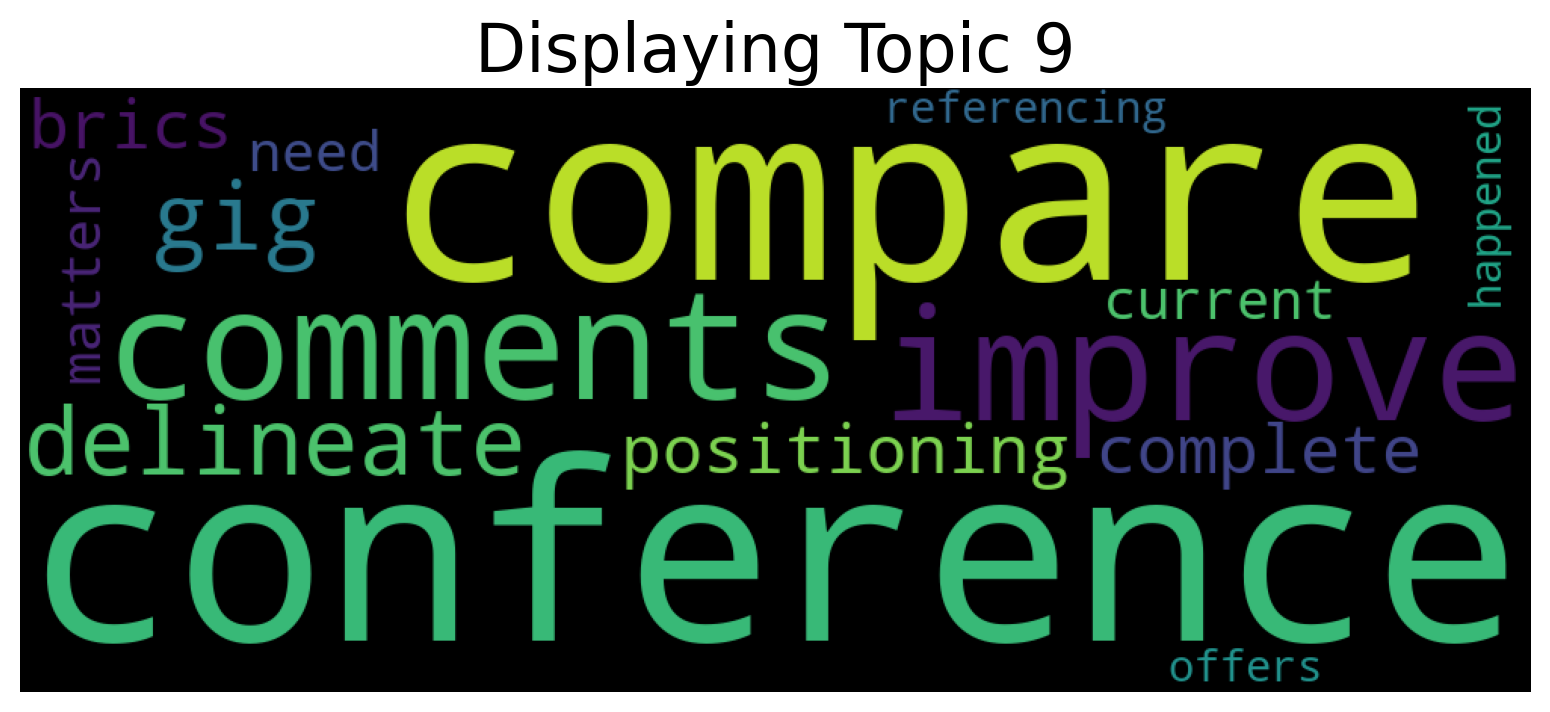

In [183]:
ctm.get_wordcloud(topic_id=9, n_words=15)

In [184]:
# PyLDAvis Visualization
lda_vis_data = ctm.get_ldavis_data_format(tp5.vocab, training_dataset, n_samples=10)
import pyLDAvis as vis
lda_vis_data = ctm.get_ldavis_data_format(tp5.vocab, training_dataset, n_samples=10)
ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

Sampling: [10/10]: : 10it [00:02,  4.45it/s]
Sampling: [10/10]: : 10it [00:02,  4.51it/s]
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [185]:
# Topic Predictions
topics_predictions = ctm.get_thetas(training_dataset, n_samples=5)
preprocessed_documents[2] 

Sampling: [5/5]: : 5it [00:01,  4.47it/s]


'operator queuing line like remind audience every quarter ask address one question adequate time take many questions possible michelle turn'

In [186]:
import numpy as np
topic_number = np.argmax(topics_predictions[0])
print(topic_number)

9


In [187]:
ctm.get_topic_lists(10)[1]

['forward',
 'quarter',
 'kramer',
 'results',
 'reiterate',
 'need',
 'rethinking',
 'another',
 'cisco',
 'matters']

In [188]:
ctm.get_topic_lists(10)[topic_number]

['conference',
 'compare',
 'improve',
 'comments',
 'delineate',
 'gig',
 'positioning',
 'brics',
 'complete',
 'current']

# III] Using ThermoFisher Dataset

In [189]:
import pickle

with open("thermofisher/2021Q3/97745_thermofisher_2021Q3.pickle", "rb") as fp:   
  data = pickle.load(fp)

print(len(data))
print(data)

3
{'transcript': {'Marc Casper': ["\nThanks, Raf. Good morning everyone, and thanks for joining us today for our Third Quarter call. We delivered another outstanding quarter, achieving exceptional financial performance while continuing to effectively execute our growth strategy to make Thermo Fisher Scientific an even stronger partner for our customers.\nAs I reflect on the year so far, three things stand out to me.\nOur proven growth strategy powered by our PPI Business System is driving outstanding financial performance.\nOur base business is performing very well and we're playing a leading role in our industry's response to COVID-19. And we continue to build on our trusted partner status with innovative new products and expanded capabilities to further enhance our unique customer value proposition.\nAll of this gives me great confidence and a very bright future as we continue to create sustainable value for all of our stakeholders, I will get into more detail on these in my remarks 

In [190]:
print(data['transcript'].keys())
thermofisher_data = data['transcript']['Marc Casper']+data['transcript']['Stephen Williamson']+data['transcript']['Rafael Tejada']

dict_keys(['Marc Casper', 'Stephen Williamson', 'Rafael Tejada', 'Patrick Donnelly', 'Tycho Peterson', 'Jack Meehan', 'Derik De Bruin', 'Dan Arias', 'Vijay Kumar', 'Dan Brennan', 'Puneet Souda', 'Operator'])


In [191]:
count=0
string_list=[]
for i in thermofisher_data:
  count = count + len (i.strip().split("\n"))
  string_list+= i.strip().split("\n") 
data_final=[]
for i in string_list:
  if (len(i)>20):
    data_final.append(i)
print(data_final[0])

Thanks, Raf. Good morning everyone, and thanks for joining us today for our Third Quarter call. We delivered another outstanding quarter, achieving exceptional financial performance while continuing to effectively execute our growth strategy to make Thermo Fisher Scientific an even stronger partner for our customers.


In [192]:
print(data_final)
print(len(data_final))

['Thanks, Raf. Good morning everyone, and thanks for joining us today for our Third Quarter call. We delivered another outstanding quarter, achieving exceptional financial performance while continuing to effectively execute our growth strategy to make Thermo Fisher Scientific an even stronger partner for our customers.', 'As I reflect on the year so far, three things stand out to me.', 'Our proven growth strategy powered by our PPI Business System is driving outstanding financial performance.', "Our base business is performing very well and we're playing a leading role in our industry's response to COVID-19. And we continue to build on our trusted partner status with innovative new products and expanded capabilities to further enhance our unique customer value proposition.", 'All of this gives me great confidence and a very bright future as we continue to create sustainable value for all of our stakeholders, I will get into more detail on these in my remarks later. But first, let me re

In [193]:
from nltk.corpus import stopwords as stop_words

nltk.download('stopwords')

stopwords = list(stop_words.words("english"))

sp = WhiteSpacePreprocessingStopwords(data_final, stopwords_list=stopwords)
preprocessed_documents, unpreprocessed_corpus, vocab, retained_indices = sp.preprocess()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [194]:
preprocessed_documents[:1]

['thanks raf good morning everyone thanks joining us today third quarter call delivered another outstanding quarter achieving exceptional financial performance continuing effectively execute growth strategy make thermo fisher scientific even stronger partner customers']

### i) all-mpnet-base-v2 Transformer

In [195]:
tp = TopicModelDataPreparation("all-mpnet-base-v2")
training_dataset = tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

/usr/local/lib/python3.7/dist-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 282 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [196]:
tp.vocab[:5]

['ability', 'able', 'absolute', 'academic', 'accelerate']

In [197]:
ctm = CombinedTM(bow_size=len(tp.vocab), contextual_size=768, n_components=20, num_epochs=10)
ctm.fit(training_dataset) 

Epoch: [10/10]	 Seen Samples: [1530/1530]	Train Loss: 193.06055325776143	Time: 0:00:00.300473: : 10it [00:02,  3.37it/s]
Sampling: [20/20]: : 20it [00:04,  4.31it/s]


In [198]:
ctm.get_topic_lists(10)

[['mentioned',
  'strengthen',
  'spectrometry',
  'process',
  'finally',
  'dan',
  'fully',
  'place',
  'innovation',
  'applied'],
 ['helping',
  'diagnostics',
  'accepted',
  'carrying',
  'rsv',
  'announced',
  'goals',
  'press',
  'evolve',
  'respiratory'],
 ['ultimately',
  'behind',
  'thermal',
  'bit',
  'nitpick',
  'us',
  'learning',
  'costs',
  'expense',
  'anything'],
 ['income',
  'bookings',
  'way',
  'track',
  'role',
  'lower',
  'math',
  'swings',
  'operating',
  'nice'],
 ['grew',
  'response',
  'decreased',
  'us',
  'guide',
  'tax',
  'felt',
  'quarter',
  'accurate',
  'mentioned'],
 ['still',
  'low',
  'colleagues',
  'unfavorable',
  'fully',
  'finally',
  'mix',
  'covid',
  'investing',
  'sciences'],
 ['system',
  'release',
  'pharma',
  'felt',
  'digits',
  'science',
  'performance',
  'ensure',
  'exciting',
  'europe'],
 ['going',
  'forward',
  'services',
  'investor',
  'begin',
  'morning',
  'invested',
  'deliver',
  'complement

In [199]:
ctm.get_topics()

defaultdict(list,
            {0: ['mentioned',
              'strengthen',
              'spectrometry',
              'process',
              'finally',
              'dan',
              'fully',
              'place',
              'innovation',
              'applied'],
             1: ['helping',
              'diagnostics',
              'accepted',
              'carrying',
              'rsv',
              'announced',
              'goals',
              'press',
              'evolve',
              'respiratory'],
             2: ['ultimately',
              'behind',
              'thermal',
              'bit',
              'nitpick',
              'us',
              'learning',
              'costs',
              'expense',
              'anything'],
             3: ['income',
              'bookings',
              'way',
              'track',
              'role',
              'lower',
              'math',
              'swings',
              'operating',
    

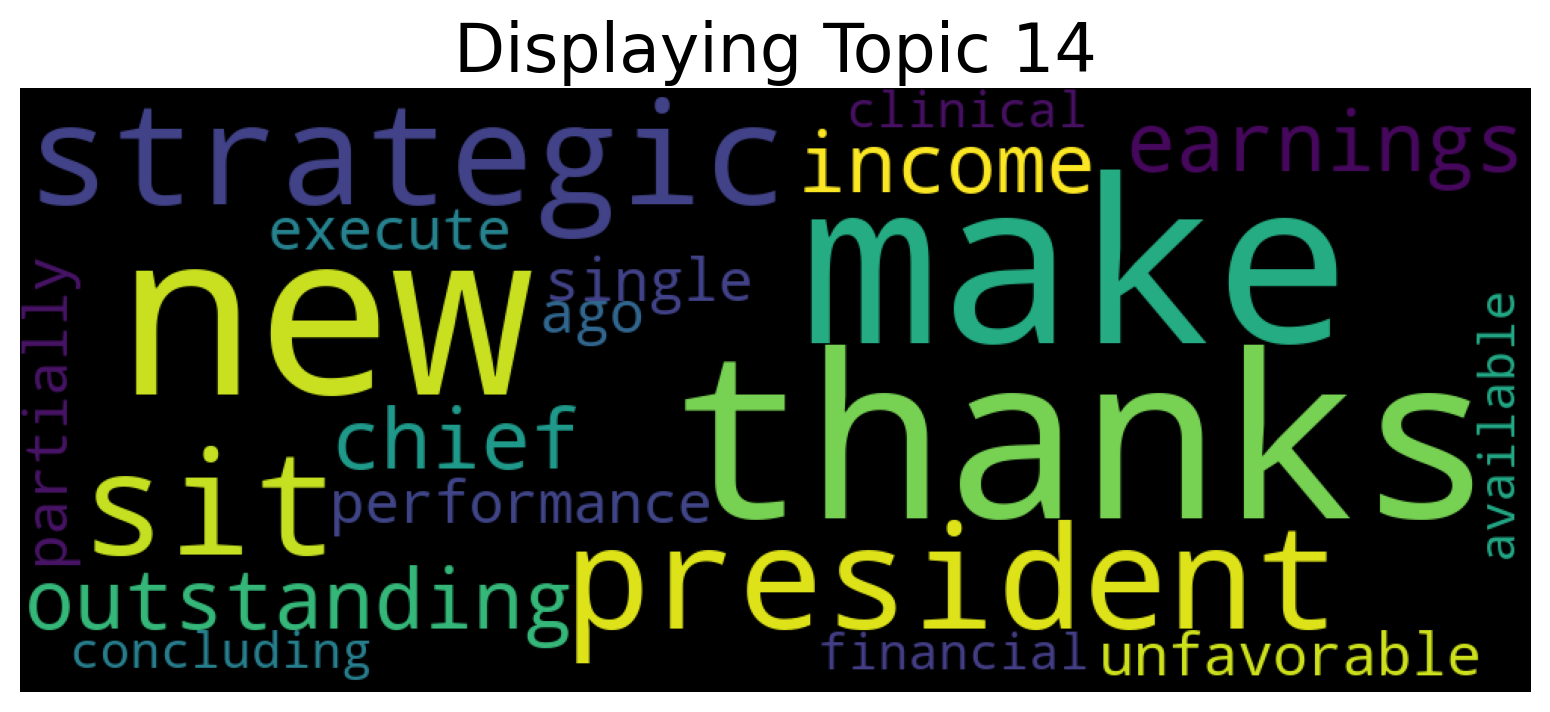

In [200]:
ctm.get_wordcloud(topic_id=14, n_words=20)

In [201]:
lda_vis_data = ctm.get_ldavis_data_format(tp.vocab, training_dataset, n_samples=10)
import pyLDAvis as vis

lda_vis_data = ctm.get_ldavis_data_format(tp.vocab, training_dataset, n_samples=10)

ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

Sampling: [10/10]: : 10it [00:02,  4.32it/s]
Sampling: [10/10]: : 10it [00:02,  4.22it/s]
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [202]:
topics_predictions = ctm.get_thetas(training_dataset, n_samples=5) # get all the topic predictions
preprocessed_documents[0]

Sampling: [5/5]: : 5it [00:01,  4.17it/s]


'thanks raf good morning everyone thanks joining us today third quarter call delivered another outstanding quarter achieving exceptional financial performance continuing effectively execute growth strategy make thermo fisher scientific even stronger partner customers'

In [203]:
import numpy as np
topic_number = np.argmax(topics_predictions[0]) # get the topic id of the first document
print(topic_number)

5


In [204]:
ctm.get_topic_lists()

[['mentioned',
  'strengthen',
  'spectrometry',
  'process',
  'finally',
  'dan',
  'fully',
  'place',
  'innovation',
  'applied'],
 ['helping',
  'diagnostics',
  'accepted',
  'carrying',
  'rsv',
  'announced',
  'goals',
  'press',
  'evolve',
  'respiratory'],
 ['ultimately',
  'behind',
  'thermal',
  'bit',
  'nitpick',
  'us',
  'learning',
  'costs',
  'expense',
  'anything'],
 ['income',
  'bookings',
  'way',
  'track',
  'role',
  'lower',
  'math',
  'swings',
  'operating',
  'nice'],
 ['grew',
  'response',
  'decreased',
  'us',
  'guide',
  'tax',
  'felt',
  'quarter',
  'accurate',
  'mentioned'],
 ['still',
  'low',
  'colleagues',
  'unfavorable',
  'fully',
  'finally',
  'mix',
  'covid',
  'investing',
  'sciences'],
 ['system',
  'release',
  'pharma',
  'felt',
  'digits',
  'science',
  'performance',
  'ensure',
  'exciting',
  'europe'],
 ['going',
  'forward',
  'services',
  'investor',
  'begin',
  'morning',
  'invested',
  'deliver',
  'complement

In [205]:
ctm.get_topic_lists(5)[5]

['still', 'low', 'colleagues', 'unfavorable', 'fully']

In [206]:
ctm.get_topic_lists(5)[topic_number] 

['still', 'low', 'colleagues', 'unfavorable', 'fully']

### ii) Finbert Transformer

In [207]:
tp1 = TopicModelDataPreparation("ProsusAI/finbert")
training_dataset = tp1.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/ProsusAI_finbert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 282 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [208]:
tp1.vocab[:10]

['ability',
 'able',
 'absolute',
 'academic',
 'accelerate',
 'accepted',
 'accordance',
 'accounting',
 'accurate',
 'achieve']

In [209]:
tp1.vocab[:]

['ability',
 'able',
 'absolute',
 'academic',
 'accelerate',
 'accepted',
 'accordance',
 'accounting',
 'accurate',
 'achieve',
 'achievement',
 'achieving',
 'acquisition',
 'acquisitions',
 'across',
 'act',
 'action',
 'actions',
 'activities',
 'activity',
 'actual',
 'actually',
 'adding',
 'addition',
 'additional',
 'address',
 'adds',
 'adjusted',
 'adjustments',
 'advance',
 'advantage',
 'advantages',
 'advocate',
 'age',
 'aggression',
 'aggressive',
 'ago',
 'align',
 'allocated',
 'allowed',
 'almost',
 'already',
 'also',
 'alternative',
 'alternatives',
 'always',
 'america',
 'amplified',
 'analysis',
 'analytical',
 'announced',
 'annual',
 'another',
 'anticipate',
 'anticipated',
 'anything',
 'applications',
 'applied',
 'approach',
 'appropriate',
 'approximately',
 'archived',
 'areas',
 'arfa',
 'around',
 'art',
 'asia',
 'asms',
 'aspects',
 'assume',
 'assumed',
 'assuming',
 'assumptions',
 'assuredness',
 'attractive',
 'august',
 'available',
 'average',


In [210]:
#Training the Combined TM
ctm = CombinedTM(bow_size=len(tp1.vocab), contextual_size=768, n_components=10, num_epochs=10)
ctm.fit(training_dataset) # run the model

Epoch: [10/10]	 Seen Samples: [1530/1530]	Train Loss: 182.99081520629085	Time: 0:00:00.283257: : 10it [00:02,  3.36it/s]
Sampling: [20/20]: : 20it [00:04,  4.28it/s]


In [211]:
# Getting the topics
ctm.get_topic_lists()

[['either',
  'ensure',
  'want',
  'take',
  'import',
  'staff',
  'spectrometer',
  'high',
  'feedback',
  'almost'],
 ['flu',
  'back',
  'value',
  'issued',
  'fashion',
  'things',
  'cfo',
  'system',
  'managing',
  'turning'],
 ['earnings',
  'process',
  'steel',
  'questions',
  'skewed',
  'none',
  'low',
  'underlying',
  'costs',
  'color'],
 ['delta',
  'lot',
  'need',
  'product',
  'swings',
  'dividends',
  'production',
  'everybody',
  'talking',
  'great'],
 ['therapies',
  'billion',
  'also',
  'million',
  'shareholders',
  'clinical',
  'continuously',
  'attractive',
  'revenue',
  'offset'],
 ['make',
  'portfolio',
  'concept',
  'forward',
  'staff',
  'way',
  'president',
  'customers',
  'sheet',
  'mandates'],
 ['take',
  'excluding',
  'map',
  'electronic',
  'said',
  'biotech',
  'addition',
  'coming',
  'specific',
  'focus'],
 ['full',
  'due',
  'initiatives',
  'included',
  'marginal',
  'interest',
  'end',
  'basis',
  'social',
  'makin

In [212]:
ctm.get_topics()

defaultdict(list,
            {0: ['either',
              'ensure',
              'want',
              'take',
              'import',
              'staff',
              'spectrometer',
              'high',
              'feedback',
              'almost'],
             1: ['flu',
              'back',
              'value',
              'issued',
              'fashion',
              'things',
              'cfo',
              'system',
              'managing',
              'turning'],
             2: ['earnings',
              'process',
              'steel',
              'questions',
              'skewed',
              'none',
              'low',
              'underlying',
              'costs',
              'color'],
             3: ['delta',
              'lot',
              'need',
              'product',
              'swings',
              'dividends',
              'production',
              'everybody',
              'talking',
              'great'],
   

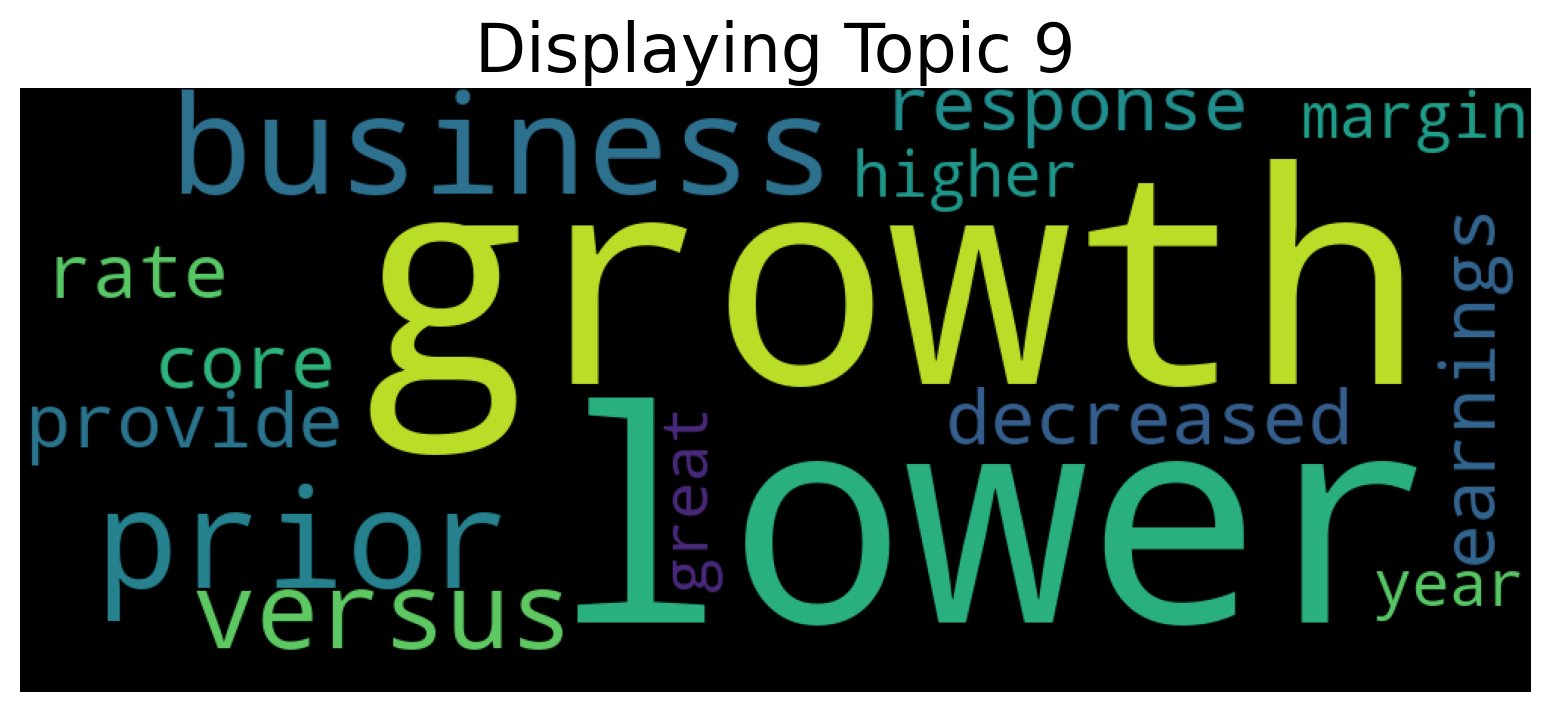

In [213]:
ctm.get_wordcloud(topic_id=9, n_words=15)

In [214]:
# pyLDAvis 
lda_vis_data = ctm.get_ldavis_data_format(tp1.vocab, training_dataset, n_samples=10)
import pyLDAvis as vis
lda_vis_data = ctm.get_ldavis_data_format(tp1.vocab, training_dataset, n_samples=10)
ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

Sampling: [10/10]: : 10it [00:02,  4.14it/s]
Sampling: [10/10]: : 10it [00:02,  4.24it/s]
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [215]:
# Topic Predictions
topics_predictions = ctm.get_thetas(training_dataset, n_samples=5) 
preprocessed_documents[0] 

Sampling: [5/5]: : 5it [00:01,  4.24it/s]


'thanks raf good morning everyone thanks joining us today third quarter call delivered another outstanding quarter achieving exceptional financial performance continuing effectively execute growth strategy make thermo fisher scientific even stronger partner customers'

In [216]:
import numpy as np
topic_number = np.argmax(topics_predictions[0]) 
print(topic_number)

4


In [217]:
ctm.get_topic_lists()

[['either',
  'ensure',
  'want',
  'take',
  'import',
  'staff',
  'spectrometer',
  'high',
  'feedback',
  'almost'],
 ['flu',
  'back',
  'value',
  'issued',
  'fashion',
  'things',
  'cfo',
  'system',
  'managing',
  'turning'],
 ['earnings',
  'process',
  'steel',
  'questions',
  'skewed',
  'none',
  'low',
  'underlying',
  'costs',
  'color'],
 ['delta',
  'lot',
  'need',
  'product',
  'swings',
  'dividends',
  'production',
  'everybody',
  'talking',
  'great'],
 ['therapies',
  'billion',
  'also',
  'million',
  'shareholders',
  'clinical',
  'continuously',
  'attractive',
  'revenue',
  'offset'],
 ['make',
  'portfolio',
  'concept',
  'forward',
  'staff',
  'way',
  'president',
  'customers',
  'sheet',
  'mandates'],
 ['take',
  'excluding',
  'map',
  'electronic',
  'said',
  'biotech',
  'addition',
  'coming',
  'specific',
  'focus'],
 ['full',
  'due',
  'initiatives',
  'included',
  'marginal',
  'interest',
  'end',
  'basis',
  'social',
  'makin

In [218]:
ctm.get_topic_lists(5)[5]

['make', 'portfolio', 'concept', 'forward', 'staff']

In [219]:
ctm.get_topic_lists(5)[topic_number] 

['therapies', 'billion', 'also', 'million', 'shareholders']

### iii) all-distilroberta-v1 Transformer

In [220]:
tp2 = TopicModelDataPreparation("all-distilroberta-v1") # instantiate a contextualized model

# create the training set
training_dataset = tp2.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

/usr/local/lib/python3.7/dist-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 282 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [221]:
tp2.vocab[:10]

['ability',
 'able',
 'absolute',
 'academic',
 'accelerate',
 'accepted',
 'accordance',
 'accounting',
 'accurate',
 'achieve']

In [222]:
ctm = CombinedTM(bow_size=len(tp2.vocab), contextual_size=768, n_components=20, num_epochs=10)
ctm.fit(training_dataset) # run the model

Epoch: [10/10]	 Seen Samples: [1530/1530]	Train Loss: 195.2325399560866	Time: 0:00:00.271798: : 10it [00:03,  3.33it/s]
Sampling: [20/20]: : 20it [00:04,  4.31it/s]


In [223]:
# Getting the topics
ctm.get_topic_lists(10)

[['combination',
  'slightly',
  'outcomes',
  'mentioned',
  'back',
  'advantage',
  'plus',
  'welcome',
  'strategic',
  'number'],
 ['center',
  'digits',
  'support',
  'progress',
  'operating',
  'generate',
  'joining',
  'offset',
  'due',
  'orders'],
 ['stephen',
  'transaction',
  'average',
  'selling',
  'surprises',
  'foundation',
  'covid',
  'last',
  'offerings',
  'carried'],
 ['transition',
  'place',
  'best',
  'analytical',
  'super',
  'advantage',
  'driven',
  'segment',
  'earnings',
  'focused'],
 ['million',
  'significant',
  'core',
  'growth',
  'business',
  'base',
  'year',
  'lower',
  'products',
  'accelerate'],
 ['covid',
  'obviously',
  'segments',
  'looks',
  'give',
  'sample',
  'position',
  'repurpose',
  'durability',
  'make'],
 ['experience',
  'value',
  'option',
  'directly',
  'elements',
  'levels',
  'appropriate',
  'segments',
  'differed',
  'organically'],
 ['focus',
  'adjusted',
  'highlighted',
  'quarters',
  'get',
  't

In [224]:
ctm.get_topics()

defaultdict(list,
            {0: ['combination',
              'slightly',
              'outcomes',
              'mentioned',
              'back',
              'advantage',
              'plus',
              'welcome',
              'strategic',
              'number'],
             1: ['center',
              'digits',
              'support',
              'progress',
              'operating',
              'generate',
              'joining',
              'offset',
              'due',
              'orders'],
             2: ['stephen',
              'transaction',
              'average',
              'selling',
              'surprises',
              'foundation',
              'covid',
              'last',
              'offerings',
              'carried'],
             3: ['transition',
              'place',
              'best',
              'analytical',
              'super',
              'advantage',
              'driven',
              'segment',
          

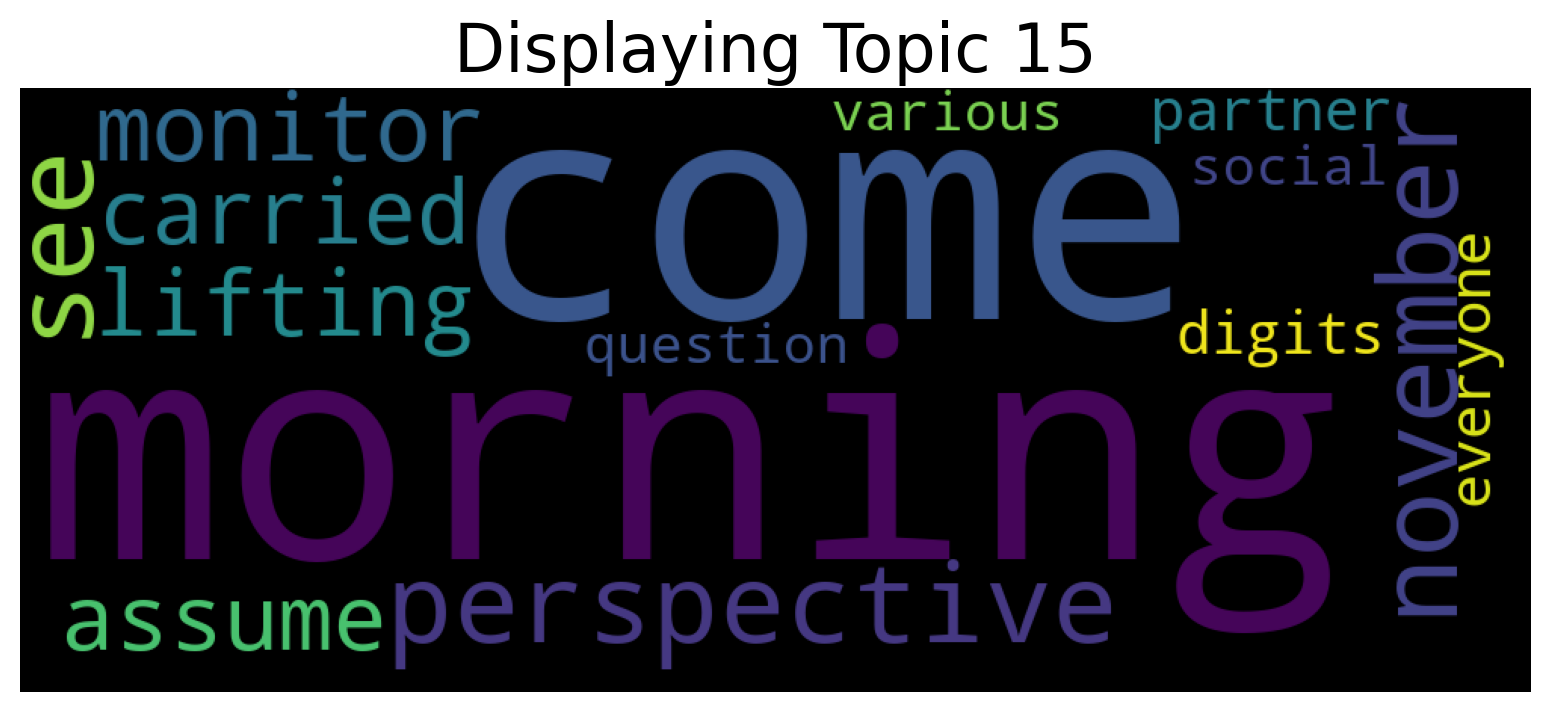

In [225]:
ctm.get_wordcloud(topic_id=15, n_words=15)

In [226]:
# PyLDAvis Visualization
lda_vis_data = ctm.get_ldavis_data_format(tp2.vocab, training_dataset, n_samples=10)
import pyLDAvis as vis
lda_vis_data = ctm.get_ldavis_data_format(tp2.vocab, training_dataset, n_samples=10)
ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

Sampling: [10/10]: : 10it [00:02,  4.21it/s]
Sampling: [10/10]: : 10it [00:02,  4.24it/s]
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [227]:
# Topic predictions
topics_predictions = ctm.get_thetas(training_dataset, n_samples=5)
preprocessed_documents[0]

Sampling: [5/5]: : 5it [00:01,  4.26it/s]


'thanks raf good morning everyone thanks joining us today third quarter call delivered another outstanding quarter achieving exceptional financial performance continuing effectively execute growth strategy make thermo fisher scientific even stronger partner customers'

In [228]:
import numpy as np
topic_number = np.argmax(topics_predictions[0])
print(topic_number)

17


In [229]:
ctm.get_topic_lists()

[['combination',
  'slightly',
  'outcomes',
  'mentioned',
  'back',
  'advantage',
  'plus',
  'welcome',
  'strategic',
  'number'],
 ['center',
  'digits',
  'support',
  'progress',
  'operating',
  'generate',
  'joining',
  'offset',
  'due',
  'orders'],
 ['stephen',
  'transaction',
  'average',
  'selling',
  'surprises',
  'foundation',
  'covid',
  'last',
  'offerings',
  'carried'],
 ['transition',
  'place',
  'best',
  'analytical',
  'super',
  'advantage',
  'driven',
  'segment',
  'earnings',
  'focused'],
 ['million',
  'significant',
  'core',
  'growth',
  'business',
  'base',
  'year',
  'lower',
  'products',
  'accelerate'],
 ['covid',
  'obviously',
  'segments',
  'looks',
  'give',
  'sample',
  'position',
  'repurpose',
  'durability',
  'make'],
 ['experience',
  'value',
  'option',
  'directly',
  'elements',
  'levels',
  'appropriate',
  'segments',
  'differed',
  'organically'],
 ['focus',
  'adjusted',
  'highlighted',
  'quarters',
  'get',
  't

In [230]:
ctm.get_topic_lists(4)[1]

['center', 'digits', 'support', 'progress']

In [231]:
ctm.get_topic_lists(5)[topic_number]

['period', 'love', 'ladens', 'stephen', 'strong']

### iv) roberta-base Transformer

In [232]:
tp3 = TopicModelDataPreparation("roberta-base") # instantiate a contextualized model

# create the training set
training_dataset = tp3.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 282 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your c

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [233]:
tp3.vocab[:4]

['ability', 'able', 'absolute', 'academic']

In [234]:
ctm = CombinedTM(bow_size=len(tp3.vocab), contextual_size=768, n_components=5, num_epochs=10)
ctm.fit(training_dataset) # run the model

Epoch: [10/10]	 Seen Samples: [1530/1530]	Train Loss: 180.9970192504085	Time: 0:00:00.273867: : 10it [00:04,  2.07it/s]
Sampling: [20/20]: : 20it [00:05,  3.58it/s]


In [235]:
ctm.get_topic_lists(5)

[['investments', 'website', 'segment', 'chief', 'quarter'],
 ['materials', 'recent', 'safety', 'period', 'bodes'],
 ['bioproduction', 'costs', 'little', 'transplant', 'including'],
 ['full', 'last', 'performance', 'goals', 'quarters'],
 ['update', 'differ', 'meaning', 'advantage', 'happens']]

In [236]:
ctm.get_topics()

defaultdict(list,
            {0: ['investments',
              'website',
              'segment',
              'chief',
              'quarter',
              'across',
              'like',
              'expecting',
              'goes',
              'outstanding'],
             1: ['materials',
              'recent',
              'safety',
              'period',
              'bodes',
              'counsels',
              'grew',
              'determined',
              'almost',
              'flow'],
             2: ['bioproduction',
              'costs',
              'little',
              'transplant',
              'including',
              'students',
              'first',
              'response',
              'presence',
              'mass'],
             3: ['full',
              'last',
              'performance',
              'goals',
              'quarters',
              'also',
              'previously',
              'revenue',
              'tota

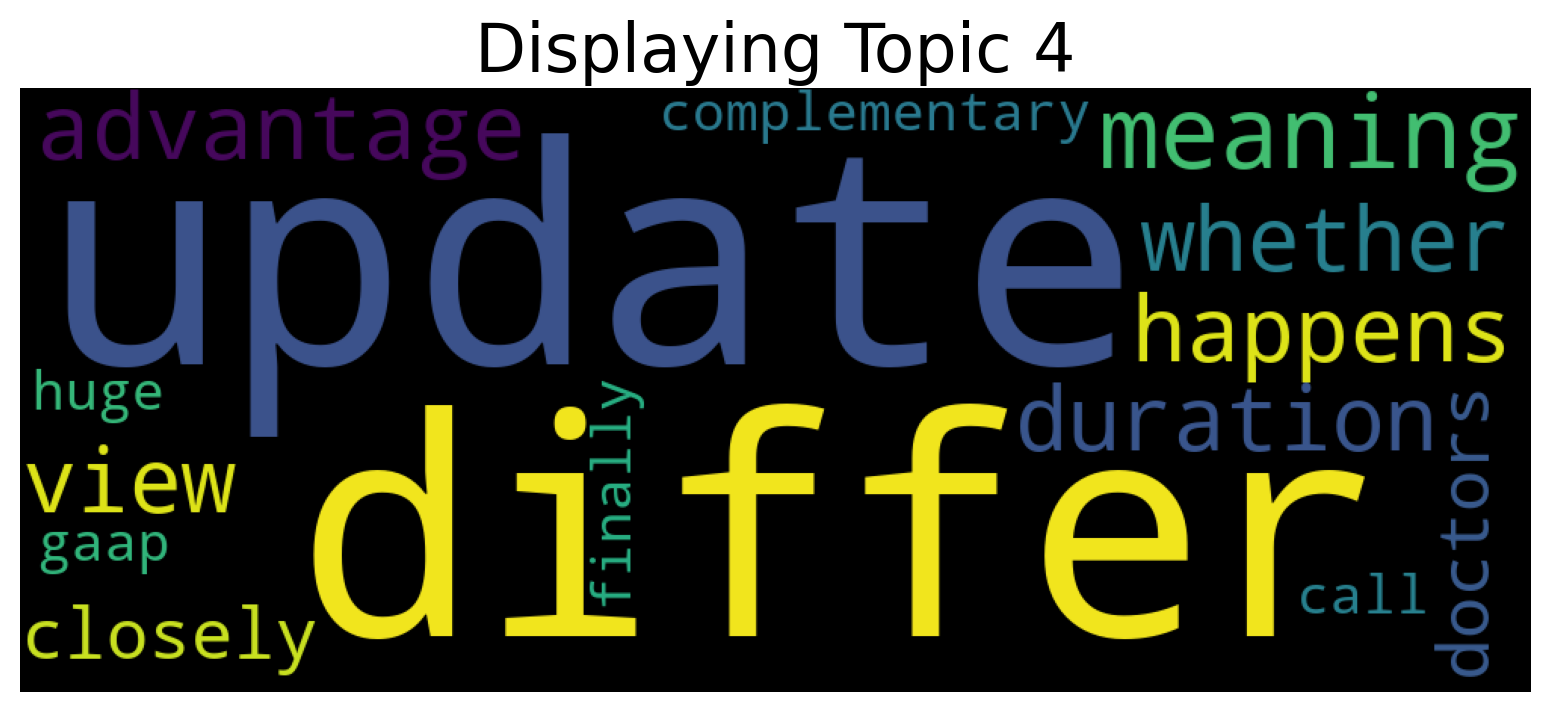

In [237]:
ctm.get_wordcloud(topic_id=4, n_words=15)

In [238]:
# PyLDAvis Visualization
lda_vis_data = ctm.get_ldavis_data_format(tp3.vocab, training_dataset, n_samples=10)
import pyLDAvis as vis
lda_vis_data = ctm.get_ldavis_data_format(tp3.vocab, training_dataset, n_samples=10)
ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

Sampling: [10/10]: : 10it [00:02,  4.20it/s]
Sampling: [10/10]: : 10it [00:02,  4.19it/s]
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [239]:
# Topic predictions
topics_predictions = ctm.get_thetas(training_dataset, n_samples=5) 
preprocessed_documents[0]

Sampling: [5/5]: : 5it [00:01,  4.35it/s]


'thanks raf good morning everyone thanks joining us today third quarter call delivered another outstanding quarter achieving exceptional financial performance continuing effectively execute growth strategy make thermo fisher scientific even stronger partner customers'

In [240]:
import numpy as np
topic_number = np.argmax(topics_predictions[0]) 
print(topic_number)

0


In [241]:
ctm.get_topic_lists(5)

[['investments', 'website', 'segment', 'chief', 'quarter'],
 ['materials', 'recent', 'safety', 'period', 'bodes'],
 ['bioproduction', 'costs', 'little', 'transplant', 'including'],
 ['full', 'last', 'performance', 'goals', 'quarters'],
 ['update', 'differ', 'meaning', 'advantage', 'happens']]

In [242]:
ctm.get_topic_lists(1)[2]

['bioproduction']

In [243]:
ctm.get_topic_lists(1)[topic_number]

['investments']

### v) all-MiniLM-L6-v2 Transformer

In [244]:
tp4 = TopicModelDataPreparation("all-MiniLM-L6-v2") # instantiate a contextualized model
# create the training set
training_dataset = tp4.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

/usr/local/lib/python3.7/dist-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 282 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [245]:
tp4.vocab[:2]

['ability', 'able']

In [246]:
tp4.vocab[:]

['ability',
 'able',
 'absolute',
 'academic',
 'accelerate',
 'accepted',
 'accordance',
 'accounting',
 'accurate',
 'achieve',
 'achievement',
 'achieving',
 'acquisition',
 'acquisitions',
 'across',
 'act',
 'action',
 'actions',
 'activities',
 'activity',
 'actual',
 'actually',
 'adding',
 'addition',
 'additional',
 'address',
 'adds',
 'adjusted',
 'adjustments',
 'advance',
 'advantage',
 'advantages',
 'advocate',
 'age',
 'aggression',
 'aggressive',
 'ago',
 'align',
 'allocated',
 'allowed',
 'almost',
 'already',
 'also',
 'alternative',
 'alternatives',
 'always',
 'america',
 'amplified',
 'analysis',
 'analytical',
 'announced',
 'annual',
 'another',
 'anticipate',
 'anticipated',
 'anything',
 'applications',
 'applied',
 'approach',
 'appropriate',
 'approximately',
 'archived',
 'areas',
 'arfa',
 'around',
 'art',
 'asia',
 'asms',
 'aspects',
 'assume',
 'assumed',
 'assuming',
 'assumptions',
 'assuredness',
 'attractive',
 'august',
 'available',
 'average',


In [247]:
ctm = CombinedTM(bow_size=len(tp4.vocab), contextual_size=384, n_components=10, num_epochs=10)
ctm.fit(training_dataset) # run the model

Epoch: [10/10]	 Seen Samples: [1530/1530]	Train Loss: 186.23562921262254	Time: 0:00:00.266326: : 10it [00:02,  3.65it/s]
Sampling: [20/20]: : 20it [00:04,  4.25it/s]


In [248]:
ctm.get_topic_lists(5)

[['gaap', 'may', 'momentum', 'obligation', 'factors'],
 ['briefly', 'specific', 'real', 'emerging', 'done'],
 ['guidance', 'details', 'basically', 'quadrupole', 'high'],
 ['biosciences', 'create', 'korea', 'attractive', 'customers'],
 ['country', 'generate', 'period', 'reform', 'efficiently'],
 ['prior', 'beat', 'science', 'performance', 'expect'],
 ['scientific', 'benefits', 'surge', 'fewer', 'deliver'],
 ['evolve', 'role', 'much', 'increased', 'benefits'],
 ['real', 'start', 'part', 'ebitda', 'file'],
 ['necessarily', 'strategy', 'couple', 'therapies', 'besides']]

In [249]:
ctm.get_topics()

defaultdict(list,
            {0: ['gaap',
              'may',
              'momentum',
              'obligation',
              'factors',
              'also',
              'third',
              'took',
              'comparable',
              'sec'],
             1: ['briefly',
              'specific',
              'real',
              'emerging',
              'done',
              'storage',
              'shared',
              'less',
              'choices',
              'environments'],
             2: ['guidance',
              'details',
              'basically',
              'quadrupole',
              'high',
              'margin',
              'difference',
              'clinical',
              'mentioned',
              'also'],
             3: ['biosciences',
              'create',
              'korea',
              'attractive',
              'customers',
              'pharm',
              'brief',
              'growth',
              'segment',
 

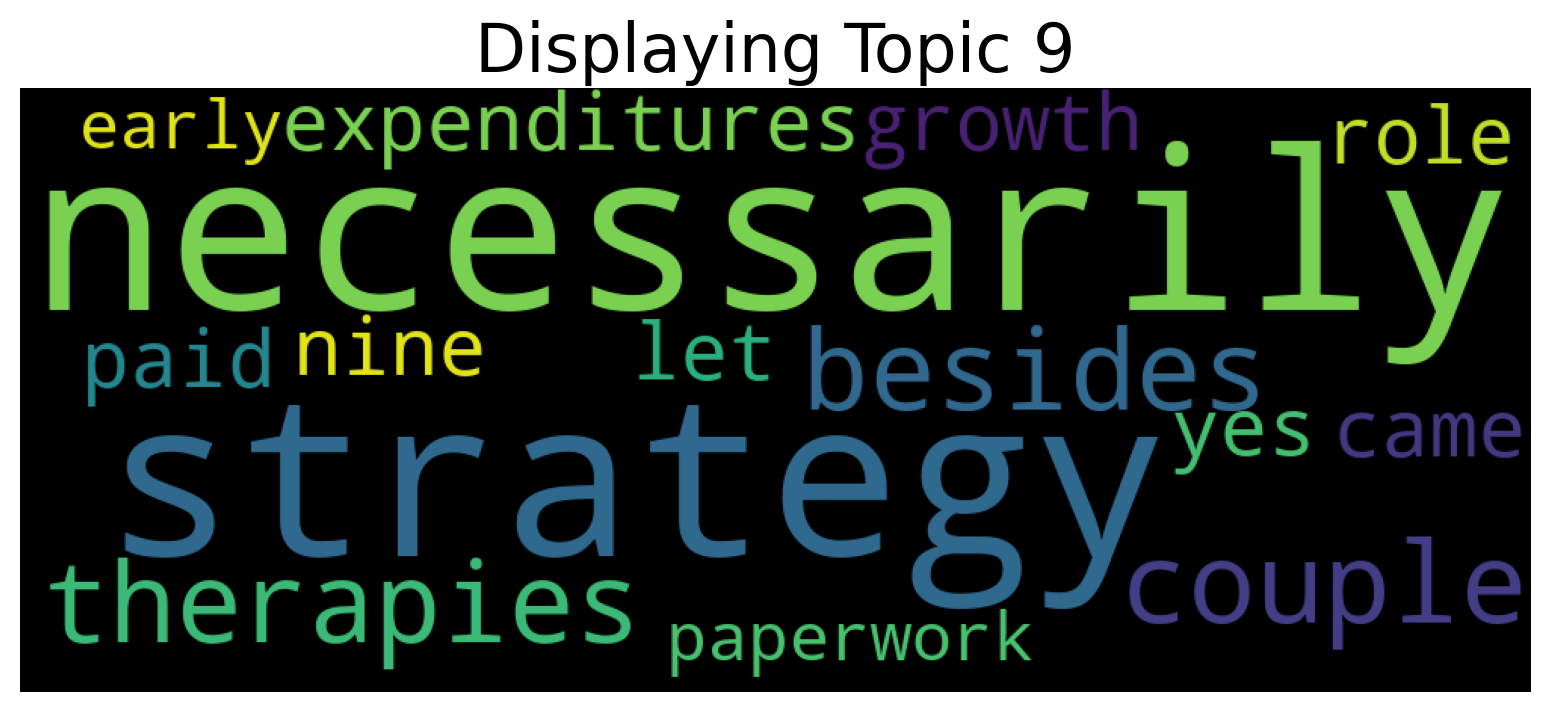

In [250]:
ctm.get_wordcloud(topic_id=9, n_words=15)

In [251]:
# PyLDAvis Visualization
lda_vis_data = ctm.get_ldavis_data_format(tp4.vocab, training_dataset, n_samples=10)
import pyLDAvis as vis
lda_vis_data = ctm.get_ldavis_data_format(tp4.vocab, training_dataset, n_samples=10)
ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

Sampling: [10/10]: : 10it [00:02,  4.24it/s]
Sampling: [10/10]: : 10it [00:02,  4.33it/s]
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [252]:
# Topic predictions
topics_predictions = ctm.get_thetas(training_dataset, n_samples=5) # get all the topic predictions

Sampling: [5/5]: : 5it [00:01,  4.36it/s]


In [253]:
preprocessed_documents[1]

'reflect year far three things stand'

In [254]:
import numpy as np
topic_number = np.argmax(topics_predictions[1]) 
print(topic_number)

1


In [255]:
ctm.get_topic_lists(1)[1]

['briefly']

In [256]:
ctm.get_topic_lists(1)[topic_number]

['briefly']

### vi) all-MiniLM-L12-v2 Transformer

In [257]:
tp5 = TopicModelDataPreparation("all-MiniLM-L12-v2") 
training_dataset = tp5.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)

/usr/local/lib/python3.7/dist-packages/contextualized_topic_models/utils/data_preparation.py:57: UserWarning: the longest document in your collection has 282 words, the model instead truncates to 128 tokens.
  warnings.warn(f"the longest document in your collection has {max_local_length} words, the model instead "


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [258]:
tp5.vocab[:1]

['ability']

In [259]:
ctm = CombinedTM(bow_size=len(tp5.vocab), contextual_size=384, n_components=10, num_epochs=10)
ctm.fit(training_dataset)

Epoch: [10/10]	 Seen Samples: [1530/1530]	Train Loss: 186.46130131740196	Time: 0:00:00.259734: : 10it [00:02,  3.64it/s]
Sampling: [20/20]: : 20it [00:04,  4.27it/s]


In [260]:
ctm.get_topic_lists(5)

[['let', 'risk', 'raising', 'pandemic', 'customers'],
 ['place', 'shares', 'business', 'similar', 'really'],
 ['good', 'capitalize', 'even', 'logistics', 'customer'],
 ['emerging', 'term', 'specifically', 'covid', 'generating'],
 ['non', 'continues', 'flow', 'amplified', 'pronouncements'],
 ['given', 'pillar', 'thoughts', 'actions', 'navigate'],
 ['provide', 'wide', 'given', 'technologies', 'significant'],
 ['year', 'puts', 'turn', 'short', 'due'],
 ['points', 'slightly', 'raising', 'ongoing', 'assumed'],
 ['included', 'end', 'services', 'private', 'indicated']]

In [261]:
ctm.get_topics(1)

defaultdict(list,
            {0: ['let'],
             1: ['place'],
             2: ['good'],
             3: ['emerging'],
             4: ['non'],
             5: ['given'],
             6: ['provide'],
             7: ['year'],
             8: ['points'],
             9: ['included']})

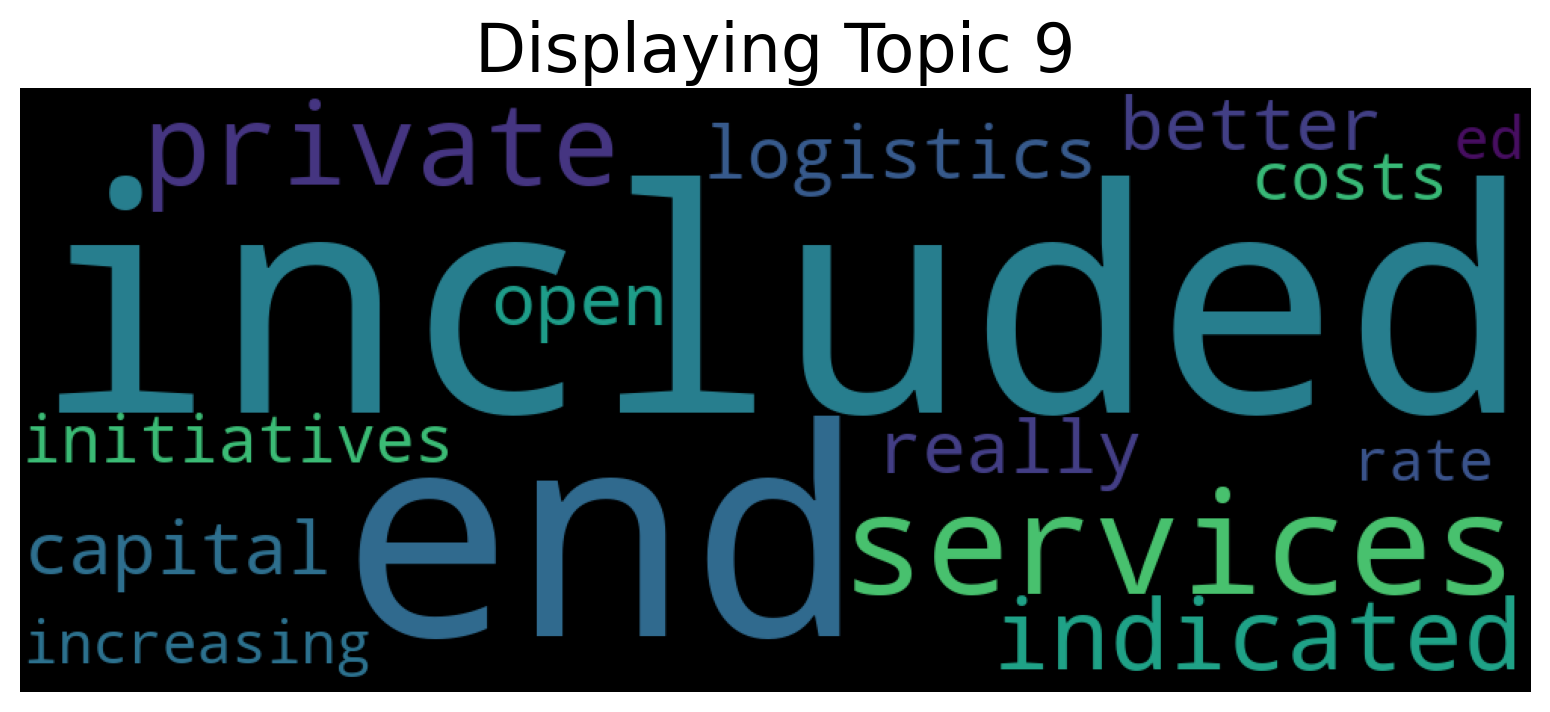

In [262]:
ctm.get_wordcloud(topic_id=9, n_words=15)

In [263]:
# PyLDAvis Visualization
lda_vis_data = ctm.get_ldavis_data_format(tp5.vocab, training_dataset, n_samples=10)
import pyLDAvis as vis
lda_vis_data = ctm.get_ldavis_data_format(tp5.vocab, training_dataset, n_samples=10)
ctm_pd = vis.prepare(**lda_vis_data)
vis.display(ctm_pd)

Sampling: [10/10]: : 10it [00:02,  4.22it/s]
Sampling: [10/10]: : 10it [00:02,  4.19it/s]
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [264]:
# Topic Predictions
topics_predictions = ctm.get_thetas(training_dataset, n_samples=5)
preprocessed_documents[2] 

Sampling: [5/5]: : 5it [00:01,  4.37it/s]


'proven growth strategy powered ppi business system driving outstanding financial performance'

In [265]:
import numpy as np
topic_number = np.argmax(topics_predictions[0])
print(topic_number)

1


In [266]:
ctm.get_topic_lists(10)[1]

['place',
 'shares',
 'business',
 'similar',
 'really',
 'difference',
 'focus',
 'logistics',
 'higher',
 'visibility']

In [267]:
ctm.get_topic_lists(10)[topic_number]

['place',
 'shares',
 'business',
 'similar',
 'really',
 'difference',
 'focus',
 'logistics',
 'higher',
 'visibility']